# Running 'lingpy'

In [84]:
import os 
import pandas as pd 
import numpy as np
import re
import math
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import igraph

from thefuzz import process
from lingpy import * # We're just importing everything from lingpy for simplicity
from lingpy import Wordlist, LexStat, Alignments, Tree, SCA # This is just to track that we used lingly module for these functions
from lingpy.sequence.sound_classes import ipa2tokens
from lingpy.compare.sanity import average_coverage, mutual_coverage_check, synonymy
from lingpy.convert.cldf import to_cldf
from datetime import datetime
from itertools import combinations
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
from shapely.geometry import Point
from collections import Counter, defaultdict
from pathlib import Path

In [85]:
# Folder name in current directory where all files (Excel, images, etc. will be saved)
results_folder_name = 'Pipeline results'

In [106]:
def load_and_validate_data(input_folder,joineddata_filename):
    """Load the initial wordlist data and perform basic validation."""
    print("=" * 50)
    print("STEP 1: Loading and validating wordlist data")
    print("=" * 50)

    # Construct the full path to the file
    file_path = os.path.join(input_folder, joineddata_filename)

    # Load wordlist using LingPy
    # Ensure the file_path exists before trying to load it
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return None # Or raise an error
    
    wordlist = Wordlist(file_path)
    print(f"Loaded wordlist with {len(wordlist)} entries\n")

    # Create LexStat object for cognate detection
    lexstat = LexStat(wordlist, merge_vowels=True, check=True)
    print("LexStat object created successfully")

    # Display sample data
    print("\nSample data (first 4 entries):")
    # Check if lexstat has enough entries before trying to access them
    num_entries = min(len(lexstat), 4)
    if num_entries > 0:
        print(tabulate([lexstat[idx] for idx in range(1, num_entries + 1)]))
    else:
        print("No entries to display.")

    return lexstat

In [107]:
lexstat_object = load_and_validate_data(results_folder_name, joineddata_filename='OCSEAN_processed_joineddata_semantic.tsv')

STEP 1: Loading and validating wordlist data
Loaded wordlist with 82837 entries



2025-07-01 12:06:23,122 [INFO] No obvious errors found in the data.


LexStat object created successfully

Sample data (first 4 entries):
----  ------  -------------  ------  ------------------  ----------------------  ------------  ----  ----  -  ------------------------------------  ---------------------  -
sun   wariy   Abui_Bunggeta  wariy   The physical world  ['w', 'a', 'r', 'iy']   [6, 7, 5, 7]  AXBZ  WARI  1  ['1.W.C', '1.A.V', '1.R.C', '1.I.V']  [2.0, 1.5, 1.75, 0.8]  0
moon  ʔuya    Abui_Bunggeta  ʔuya    The physical world  ['ʔ', 'uya']            [1, 7]        AX    HY    1  ['1.H.C', '1.Y.V']                    [2.0, 1.5]             0
star  furiy   Abui_Bunggeta  furiy   The physical world  ['f', 'u', 'r', 'iy']   [3, 7, 5, 7]  AXBZ  BYRI  1  ['1.B.C', '1.Y.V', '1.R.C', '1.I.V']  [2.0, 1.5, 1.75, 0.8]  0
sky   ʔadiiy  Abui_Bunggeta  ʔadiiy  The physical world  ['ʔ', 'a', 'd', 'iiy']  [1, 7, 1, 7]  AXBZ  HATI  1  ['1.H.C', '1.A.V', '1.T.C', '1.I.V']  [2.0, 1.5, 1.75, 0.8]  0
----  ------  -------------  ------  ------------------  ----------

In [108]:
def analyze_data_coverage(lexstat_object):
    """Analyze the coverage and quality of the dataset."""
    print("\n" + "=" * 50)
    print("STEP 2: Analyzing data coverage")
    print("=" * 50)
    
    # Calculate average coverage
    avg_coverage = average_coverage(lexstat_object)
    print(f'Average coverage: {avg_coverage:.2f}')
    
    # Check for synonyms (multiple words for same concept in same language)
    synonyms = synonymy(lexstat_object)
    num_synonyms = len(lexstat_object) - len(synonyms)
    syn_ratio = 1 - (len(synonyms) / len(lexstat_object))
    
    if num_synonyms == 0:
        print(f'Found {num_synonyms} potential synonyms.')
    else:
        print(f'Found {num_synonyms} potential synonyms ({syn_ratio*100.0:.2f}%):')
        # Show languages/concepts with high synonym counts
        for (language, concept), count in sorted(synonyms.items(), key=lambda x: x[0][0]):
            if count > 10:
                print(f'{language:15}  {concept:12}  {count}')
    
    return synonyms

In [109]:
synonyms_results = analyze_data_coverage(lexstat_object=lexstat_object)


STEP 2: Analyzing data coverage
Average coverage: 0.34
Found 11940 potential synonyms (14.41%):


In [110]:
def detect_cognates(results_folder_name,lexstat_object, cognate_threshold=None, export_filename=None, verbose=False):
    """Detect cognate sets using LexStat algorithm.
    
    Args:
        lexstat_object: LexStat object with loaded wordlist data
        cognate_threshold: Threshold for cognate detection (default: 0.55)
        export_filename: Base filename for output (default: 'detect_cognates_function_results')
        verbose: If True, shows detailed progress. If False, suppresses output.
    """
    print("\n" + "=" * 50)
    print("STEP 3: Detecting cognate sets")
    print("=" * 50)
    
    # Use default values if not provided
    if cognate_threshold is None:
        cognate_threshold = 0.55
    if export_filename is None:
        export_filename = 'detect_cognates_function_results.tsv'
    
    # Get scorer for cognate detection
    print("Computing sound correspondence patterns...")
    
    # Check if scorer already exists and force recalculation if needed
    force_scorer = False
    if hasattr(lexstat_object, 'cscorer') and lexstat_object.cscorer is not None:
        if verbose:
            print("Existing scorer found, forcing recalculation...")
        force_scorer = True
    
    try:
        if verbose:
            # Show detailed progress including correspondence calculations
            lexstat_object.get_scorer(force=force_scorer)
        else:
            # Suppress verbose output using LingPy's built-in verbosity control
            import logging
            import os
            
            # Store original settings
            original_level = logging.getLogger('lingpy').level
            original_verbose = os.environ.get('LINGPY_LOG', '')
            
            # Set quiet mode
            logging.getLogger('lingpy').setLevel(logging.ERROR)
            os.environ['LINGPY_LOG'] = 'ERROR'
            
            try:
                # Use LingPy's progress bar suppression if available
                try:
                    from lingpy.settings import rcParams
                    original_progress = rcParams.get('verbose', True)
                    rcParams['verbose'] = False
                except:
                    original_progress = None
                
                lexstat_object.get_scorer(force=force_scorer)
                
                # Restore progress setting
                if original_progress is not None:
                    try:
                        rcParams['verbose'] = original_progress
                    except:
                        pass
                        
            finally:
                # Restore original logging settings
                logging.getLogger('lingpy').setLevel(original_level)
                if original_verbose:
                    os.environ['LINGPY_LOG'] = original_verbose
                else:
                    os.environ.pop('LINGPY_LOG', None)
    
    except Exception as e:
        print(f"Error during scorer creation: {e}")
        print("Retrying scorer creation with force=True and verbose output...")
        try:
            lexstat_object.get_scorer(force=True)
        except Exception as e2:
            print(f"Scorer creation failed again: {e2}")
            raise RuntimeError("Unable to create scorer for cognate detection") from e2
    
    # Verify scorer was created successfully
    if not hasattr(lexstat_object, 'cscorer') or lexstat_object.cscorer is None:
        print("Warning: Scorer creation may have failed. Retrying with verbose output...")
        try:
            lexstat_object.get_scorer(force=True)  # Force recreation with verbose output
        except Exception as e:
            print(f"Final scorer creation attempt failed: {e}")
            raise RuntimeError("Unable to create scorer for cognate detection") from e
        
        # Final check
        if not hasattr(lexstat_object, 'cscorer') or lexstat_object.cscorer is None:
            raise RuntimeError("Scorer creation succeeded but cscorer attribute is still missing")
    
    print("Sound correspondence patterns computed successfully!")
    
    # Verify we have the necessary attributes for clustering
    required_attrs = ['cscorer', '_numbers', '_prostrings']
    missing_attrs = [attr for attr in required_attrs if not hasattr(lexstat_object, attr)]
    if missing_attrs:
        raise RuntimeError(f"LexStat object is missing required attributes: {missing_attrs}")
    
    # Cluster cognates using LexStat with infomap clustering
    print(f"Clustering cognates (threshold: {cognate_threshold})...")
    
    try:
        if verbose:
            lexstat_object.cluster(
                method='lexstat', 
                threshold=cognate_threshold, 
                cluster_method='infomap', 
                ref='cogid'
            )
        else:
            # Suppress clustering progress as well
            import logging
            import os
            
            original_level = logging.getLogger('lingpy').level
            original_verbose = os.environ.get('LINGPY_LOG', '')
            
            logging.getLogger('lingpy').setLevel(logging.ERROR)
            os.environ['LINGPY_LOG'] = 'ERROR'
            
            try:
                # Also try to suppress progress bars
                try:
                    from lingpy.settings import rcParams
                    original_progress = rcParams.get('verbose', True)
                    rcParams['verbose'] = False
                except:
                    original_progress = None
                
                lexstat_object.cluster(
                    method='lexstat', 
                    threshold=cognate_threshold, 
                    cluster_method='infomap', 
                    ref='cogid'
                )
                
                # Restore progress setting
                if original_progress is not None:
                    try:
                        rcParams['verbose'] = original_progress
                    except:
                        pass
                        
            finally:
                logging.getLogger('lingpy').setLevel(original_level)
                if original_verbose:
                    os.environ['LINGPY_LOG'] = original_verbose
                else:
                    os.environ.pop('LINGPY_LOG', None)
    
    except Exception as e:
        print(f"Error during clustering: {e}")
        print("This might be due to data issues or threshold problems.")
        print("Try adjusting the cognate_threshold or checking your data.")
        raise
    
    # Output results to TSV file
    try:
        # Construct the full path for the output TSV file.
        # 'export_filename' should be just the file's name, including its '.tsv' extension
        # (e.g., "my_cognates.tsv" or "report_data.tsv"), without any directory path.
        full_output_path = os.path.join(results_folder_name, export_filename)

        lexstat_object.output('tsv', filename=full_output_path)
        print(f"Cognate results saved to: {full_output_path}")
    except Exception as e:
        print(f"Error saving results: {e}")
        print("Cognate detection completed but file output failed.")

    print("Cognate detection completed successfully!")
    
    return lexstat_object

The code below can take around 15-20 minutes, more or less, depending on the computer used.

In [111]:
cognate_threshold = .55
export_filename = 'detect_cognates_function_results'

cognates_detected = detect_cognates(results_folder_name,lexstat_object, cognate_threshold=cognate_threshold, export_filename=export_filename, verbose=False)


STEP 3: Detecting cognate sets
Computing sound correspondence patterns...


Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-07-01 12:17:41,383 [INFO] Data has been written to file <Pipeline results/detect_cognates_function_results.tsv>.                                                                                     


Cognate results saved to: Pipeline results/detect_cognates_function_results
Cognate detection completed successfully!


In [123]:
lexdf=pd.read_table(os.path.join(results_folder_name,'detect_cognates_function_results.tsv'),skiprows=2,comment='#')

In [125]:
def compute_cognate_overlaps(results_folder_name):
    """
    Counts the number of cognate words for each language pair and produces two matrices, one for the counts
    and another for the 
    Args:
        results_folder_name: the folder of where to read results from lingpy cognate detection.
    Returns:
        Nothing
    """
    print("\n" + "=" * 50)
    print("STEP 5: Performing sequence alignment and calculating distances")
    print("=" * 50)
    # Get unique list of languages
    lexdf=pd.read_table(os.path.join(results_folder_name,'detect_cognates_function_results.tsv'),skiprows=2,comment='#')
    mylanguages = sorted(lexdf['DOCULECT'].unique())
    lang_idx = {lang: i for i, lang in enumerate(mylanguages)}

    # Initialize matrix
    matrix = np.zeros((len(mylanguages), len(mylanguages)), dtype=int)

    # Group by cognate set
    for cogid, group in lexdf.groupby('COGID'):
        langs = group['DOCULECT'].unique()
        for lang1, lang2 in combinations(langs, 2):
            i, j = lang_idx[lang1], lang_idx[lang2]
            matrix[i][j] += 1
            matrix[j][i] += 1  # Because it's undirected

    # Optional: fill diagonal with how many unique cognate sets each language has
    for lang in mylanguages:
        matrix[lang_idx[lang]][lang_idx[lang]] = lexdf[lexdf['DOCULECT'] == lang]['COGID'].nunique()

    # Turn into a pandas DataFrame
    adj_df = pd.DataFrame(matrix, index=mylanguages, columns=mylanguages)
    # Save
    adj_df.to_csv(os.path.join(results_folder_name,'OCSEAN_cognate_adjacency_matrix.csv'))
    # Assuming adj_df is a symmetric matrix
    diagonal = np.diag(adj_df)
    scaling_factors = np.sqrt(np.outer(diagonal, diagonal))

    # Element-wise division
    scaled_df = adj_df / scaling_factors

    # Convert back to DataFrame with same labels
    scaled_df = pd.DataFrame(scaled_df, index=adj_df.index, columns=adj_df.columns)
    scaled_df.to_csv(os.path.join(results_folder_name,'OCSEAN_scaled_cognate_adjacency_matrix.csv'))

In [126]:
## Report cognate overlaps
compute_cognate_overlaps(results_folder_name)

In [141]:
def perform_alignment_and_process_distances(results_folder_name,filename, align_method='library'):
    """
    Performs sequence alignment, calculates distances, and processes the distance matrix.
    Args:
        filename (str): The base filename for the input TSV and output files.
        align_method (str, optional): The alignment method to use. Defaults to 'library'.
    Returns:
        tuple: A tuple containing:
            - alignments (lingpy.Alignments): The alignments object.
            - dist_matrix (pandas.DataFrame): The processed symmetric distance matrix.
    """
    print("\n" + "=" * 50)
    print("STEP 5: Performing sequence alignment and calculating distances")
    print("=" * 50)

    # Construct the full path to the file
    file_path = os.path.join(results_folder_name, f'{filename}.tsv')

    # Load wordlist using LingPy
    # Ensure the file_path exists before trying to load it
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return None # Or raise an error
    
    # Load data for alignment
    lexstat_proc = LexStat(file_path, check=True)
    
    # Create alignments object
    alignments = Alignments(
        lexstat_proc,
        transcription='WORD',
        ref="COGID",
        segments="segments"
    )
    
    # Perform alignment using library method
    print("Aligning sequences...")
    alignments.align(method=align_method)
    
    # Calculate distance matrix
    print("Calculating distance matrix...")
    distances = alignments.get_distances(ref='cogid')

    alignments.output('dst', filename=os.path.join(results_folder_name,'OCSEAN_processed_distances'))
    tdists=pd.read_table(os.path.join(results_folder_name,'OCSEAN_processed_distances.dst'),skiprows=1,header=None)

    theaders = list(tdists.iloc[:,0])
    dists  = pd.DataFrame(tdists.values[:,1:], columns=theaders,index=theaders)
    dist_matrix = dists[dists.columns].astype(float)  # or int

    # Display final results
    print(f"\nFinal dist_matrix shape: {dist_matrix.shape}")
    if not dist_matrix.empty:
        print("Final dist_matrix:")
        print(f"Column names: {list(dist_matrix.columns)[:10]}...")  # Show first 10
        
        # Verify the matrix is symmetric (as expected for distance matrices)
        if dist_matrix.shape[0] == dist_matrix.shape[1]:
            is_symmetric = np.allclose(dist_matrix.values, dist_matrix.values.T, rtol=1e-10)
            print(f"Matrix is symmetric: {is_symmetric}\n")
        
    return alignments, dist_matrix

In [142]:
OCSEAN_processed_alignments, OCSEAN_processed_distances = perform_alignment_and_process_distances(results_folder_name,filename=export_filename, align_method='library')
OCSEAN_processed_distances


STEP 5: Performing sequence alignment and calculating distances


2025-07-01 14:20:54,102 [INFO] No obvious errors found in the data.


Aligning sequences...
Calculating distance matrix...


2025-07-01 14:22:19,564 [ERROR] Zero-division error encountered in 'Bali_Aga' and 'Sabu_Seba'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: division by zero
2025-07-01 14:22:24,253 [ERROR] Zero-division error encountered in 'Kupang_Malay' and 'Sabu_Seba'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: division by zero
2025-07-01 14:22:25,405 [ERROR] Zero-division error encountered in 'Sabu_Seba' and 'Sangil'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (


Final dist_matrix shape: (78, 78)
Final dist_matrix:
Column names: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Alurung']...
Matrix is symmetric: True



,Abui_Bunggeta,Abui_Kilakawada,Abui_Mobyetang,Abui_Pelman,Adang,Agta,Agusan_Manobo,Agutaynen,Akeanon,Alurung,...,Tagakaulo,Tagbanwa_Central,Talaandig,Tausug,Tboli,Tuwali,Uab_Meto,Umbu-Ungu,Waray,Yakan
Abui_Bunggeta,0.0000,0.2200,0.2843,0.3043,0.7981,0.9785,0.9660,0.9749,0.9679,0.9252,...,0.9571,0.9788,0.9769,0.9753,0.9840,0.9873,0.9796,0.9843,0.9617,0.9717
Abui_Kilakawada,0.2200,0.0000,0.3462,0.3729,0.8028,0.9871,0.9728,0.9875,0.9804,0.9346,...,0.9785,0.9858,0.9769,0.9815,0.9822,0.9924,0.9878,0.9862,0.9774,0.9858
Abui_Mobyetang,0.2843,0.3462,0.0000,0.2131,0.8028,0.9849,0.9744,0.9791,0.9839,0.9393,...,0.9763,0.9894,0.9768,0.9835,0.9858,0.9975,0.9857,0.9862,0.9773,0.9840
Abui_Pelman,0.3043,0.3729,0.2131,0.0000,0.8019,0.9871,0.9727,0.9748,0.9821,0.9437,...,0.9698,0.9858,0.9744,0.9793,0.9840,0.9924,0.9836,0.9862,0.9773,0.9787
Adang,0.7981,0.8028,0.8028,0.8019,0.0000,0.9619,0.9522,0.9543,0.9469,0.9004,...,0.9533,0.9471,0.9641,0.9358,0.9602,0.9650,0.9628,0.9771,0.9467,0.9425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tuwali,0.9873,0.9924,0.9975,0.9924,0.9650,0.7229,0.7799,0.7933,0.7556,0.8500,...,0.7687,0.7433,0.7491,0.7974,0.8556,0.0000,0.9291,0.9790,0.7786,0.8087
Uab_Meto,0.9796,0.9878,0.9857,0.9836,0.9628,0.9298,0.9458,0.9385,0.9316,0.8796,...,0.9269,0.9302,0.9356,0.9272,0.9474,0.9291,0.0000,0.9937,0.9296,0.9324
Umbu-Ungu,0.9843,0.9862,0.9862,0.9862,0.9771,0.9623,0.9810,0.9793,0.9757,0.9863,...,0.9815,0.9783,0.9753,0.9833,0.9833,0.9790,0.9937,0.0000,0.9836,0.9811
Waray,0.9617,0.9774,0.9773,0.9773,0.9467,0.7293,0.5808,0.6697,0.5023,0.8267,...,0.6284,0.6763,0.6501,0.7132,0.8329,0.7786,0.9296,0.9836,0.0000,0.7636


In [143]:
# Export Distance Matrix
file_name = 'OCSEAN_processed_distance_matrix.csv'
output_file_path = os.path.join(results_folder_name, file_name)

try:
    OCSEAN_processed_distances.to_csv(output_file_path)
    print(f"File '{file_name}' exported successfully to '{results_folder_name}' folder.")
except Exception as e:
    print(f"An error occurred during export: {e}")

File 'OCSEAN_processed_distance_matrix.csv' exported successfully to 'Pipeline results' folder.


In [91]:
def build_phylogenetic_tree(results_folder_name,alignments_results):
    """Build and display phylogenetic tree."""
    print("\n" + "=" * 50)
    print("STEP 7: Building phylogenetic tree")
    print("=" * 50)
    
    # Generate tree using UPGMA method
    tree = Tree(alignments_results.get_tree(ref='cogid', tree_calc='upgma', force=True))
    
    print("Phylogenetic tree (ASCII representation):")
    print(tree.asciiArt(compact=True))
    # Export tree in NEXUS format for external analysis
    #nexus_file = "ocsean_phylogeny"
    #alignments_results.output('nexus', filename=nexus_file, mode="BEAST")
    #print(f"Tree exported to: {nexus_file}.nex")

    # Export
    file_name = "ocsean_phylogeny"
    output_file_path = os.path.join(results_folder_name, f'{file_name}.nexus')

    try:
        #adj_scaled_df.to_csv(output_file_path, index=False) # index=False prevents writing DataFrame index to Excel
        alignments_results.output('nexus', filename=file_name, mode="BEAST")
        print(f"File '{file_name}' exported successfully to '{results_folder_name}' folder.")
    except Exception as e:
        print(f"An error occurred during export: {e}") 
    return tree

In [42]:
tree_results = build_phylogenetic_tree(results_folder_name,alignments_results=OCSEAN_processed_alignments)

2025-07-01 10:32:54,351 [INFO] Successfully calculated tree.



STEP 7: Building phylogenetic tree
Phylogenetic tree (ASCII representation):
          /edge.0-- /-Mawes_Wares
         |          \-Mawesdai
         |          /-Umbu-Ungu
-root----|         |                    /-Mauta
         |         |          /edge.7--|                    /edge.1-- /-Abui_Mobyetang
         |         |         |         |          /edge.3--|          \-Abui_Pelman
          \edge.75-|         |          \edge.6--|          \edge.2-- /-Abui_Bunggeta
                   |         |                   |                    \-Abui_Kilakawada
                   |         |                    \edge.5-- /-Kelon
                   |         |                              \edge.4-- /-Adang
                    \edge.74-|                                        \-Reta
                             |                    /edge.8-- /-Ba_a
                             |          /edge.11-|          \-Dela
                             |         |          \edge.10- /-Uab_Meto
    

In [92]:
def create_and_normalize_cognate_adjacency_matrix(results_folder_name,cognates_detected_results, OUTPUT_PREFIX='OCSEAN_processed'):
    """
    Performs sequence alignment, calculates distances, and processes the distance matrix.

    Args:
        filename (str): The base filename for the input TSV and output files.
        align_method (str, optional): The alignment method to use. Defaults to 'library'.

    Returns:
        tuple: A tuple containing:
            - adj_df (pandas.DataFrame): The raw cognate adjacency matrix.
            - scaled_df (pandas.DataFrame): The adjacency matrix scaled by the geometric mean of diagonal elements.
            - adj_scaled_df (pandas.DataFrame): The adjacency matrix after log-transform and standardization.
    """
    print("\n" + "=" * 50)
    print("STEP 8: Creating cognate adjacency matrix")
    print("=" * 50)

    # Handle different input types for cognates_detected_results
    if cognates_detected_results is None:
        raise ValueError("cognates_detected_results is None. Please check the cognate detection step.")

    # Convert LexStat object to DataFrame if needed
    if hasattr(cognates_detected_results, 'get_dict'):
        print("\nConverting LexStat object to DataFrame...")
        try:
            if hasattr(cognates_detected_results, 'raw'):
                raw_data = cognates_detected_results.raw
                if isinstance(raw_data, list) and len(raw_data) > 0:
                    header_row = None
                    data_rows = []
                    for i, row in enumerate(raw_data):
                        if i < 3:
                            continue
                        if not row or (len(row) == 1 and row[0] == '#') or all(cell == '#' or cell == '' for cell in row):
                            continue
                        if header_row is None:
                            header_row = row
                        else:
                            data_rows.append(row)

                    if header_row and data_rows:
                        cognates_df = pd.DataFrame(data_rows, columns=header_row)
                        print(f"Successfully created DataFrame from raw data with {len(data_rows)} rows")
                    else:
                        raise ValueError("Could not find valid header row or data rows in raw data.")
                else:
                    raise ValueError("Raw data is not in expected list of lists format.")
            else:
                # Fallback to original method (if raw data not directly accessible)
                raise ValueError("No raw data attribute found, attempting alternative conversion.")

        except Exception as e:
            print(f"Error converting LexStat to DataFrame using raw data: {e}")
            print("\nAttempting alternative conversion method (iterating indices)...")
            try:
                data_list = []
                for idx in cognates_detected_results:
                    try:
                        row_data = {
                            'DOCULECT': cognates_detected_results[idx, 'doculect'],
                            'CONCEPT': cognates_detected_results[idx, 'concept'],
                            'WORD': cognates_detected_results[idx, 'word'],
                            'COGID': cognates_detected_results[idx, 'cogid']
                        }
                        data_list.append(row_data)
                    except Exception as idx_error:
                        print(f"Error processing index {idx}: {idx_error}")
                        continue

                if data_list:
                    cognates_df = pd.DataFrame(data_list)
                    print(f"Successfully created DataFrame from indices with {len(data_list)} rows")
                else:
                    raise ValueError("No valid data found in LexStat object via index iteration.")

            except Exception as e2:
                print(f"Error with alternative index iteration method: {e2}")
                print("\nAttempting direct get_dict conversion with filtering...")
                try:
                    data_dict = cognates_detected_results.get_dict()
                    cognates_df = pd.DataFrame(data_dict).T

                    if cognates_df.empty or cognates_df.shape[0] < 4:
                        raise ValueError("DataFrame appears to be empty or malformed after get_dict.")

                    if cognates_df.shape[0] > 3:
                        first_row = cognates_df.iloc[0]
                        if pd.isna(first_row).all() or (first_row == '#').all():
                            print("Removing metadata rows from get_dict DataFrame...")
                            cognates_df = cognates_df.iloc[3:].reset_index(drop=True)

                    print(f"Successfully created DataFrame with shape: {cognates_df.shape}")

                except Exception as e3:
                    raise ValueError(f"All conversion methods failed. Last error: {e3}")
    else:
        # If it's already a DataFrame, clean it if needed
        cognates_df = cognates_detected_results.copy()

        # Check if we need to remove header rows
        if cognates_df.shape[0] > 3:
            first_few_rows = cognates_df.head(3)
            if first_few_rows.isnull().all().all() or (first_few_rows == '#').all().all():
                print("Removing metadata rows from DataFrame...")
                cognates_df = cognates_df.iloc[3:].reset_index(drop=True)

    # Remove any remaining comment rows (rows where all values are '#' or empty)
    if not cognates_df.empty:
        comment_mask = cognates_df.apply(lambda row: all(pd.isna(val) or val == '#' or val == '' for val in row), axis=1)
        if comment_mask.any():
            print(f"Removing {comment_mask.sum()} comment rows...")
            cognates_df = cognates_df[~comment_mask].reset_index(drop=True)

    # Check if DataFrame is empty after cleaning
    if cognates_df.empty:
        raise ValueError("Empty dataset provided for adjacency matrix creation after cleaning.")

    # Print info about the cleaned DataFrame
    print(f"Cleaned DataFrame shape: {cognates_df.shape}")
    print(f"Available columns: {list(cognates_df.columns)}")

    # Identify the correct column names (case-insensitive)
    column_mapping = {}
    for required_col in ['DOCULECT', 'LANGUAGE', 'COGID']:
        found = False
        for col in cognates_df.columns:
            if col.upper() == required_col:
                column_mapping[required_col] = col
                found = True
                break
        if not found and required_col == 'DOCULECT' and 'LANGUAGE' in [c.upper() for c in cognates_df.columns]:
            for col in cognates_df.columns:
                if col.upper() == 'LANGUAGE':
                    column_mapping['DOCULECT'] = col
                    found = True
                    break

    # Use the correct column names
    doculect_col = column_mapping.get('DOCULECT', 'DOCULECT')
    cogid_col = column_mapping.get('COGID', 'COGID')

    # Verify required columns exist
    if doculect_col not in cognates_df.columns:
        available_cols = list(cognates_df.columns)
        raise ValueError(f"Required language column '{doculect_col}' not found. Available columns: {available_cols}")

    if cogid_col not in cognates_df.columns:
        available_cols = list(cognates_df.columns)
        raise ValueError(f"Required cognate ID column '{cogid_col}' not found. Available columns: {available_cols}")

    # Get unique languages
    languages = sorted(cognates_df[doculect_col].unique())
    n_languages = len(languages)
    print(f"\nFound {n_languages} languages: {languages[:5]}..." if n_languages > 5 else f"Languages: {languages}")

    # Create language index mapping
    lang_idx = {lang: i for i, lang in enumerate(languages)}

    # Initialize adjacency matrix
    matrix = np.zeros((n_languages, n_languages), dtype=int)

    # Fill matrix based on shared cognate sets
    print("\nComputing cognate sharing patterns...")
    cognate_groups = cognates_df.groupby(cogid_col)

    for cogid, group in cognate_groups:
        langs_in_cognate = group[doculect_col].unique()
        # For each pair of languages sharing this cognate
        for lang1, lang2 in combinations(langs_in_cognate, 2):
            i, j = lang_idx[lang1], lang_idx[lang2]
            matrix[i, j] += 1
            matrix[j, i] += 1  # Symmetric matrix

    # Fill diagonal with number of unique cognate sets per language
    for lang in languages:
        lang_cognates = cognates_df[cognates_df[doculect_col] == lang][cogid_col].nunique()
        matrix[lang_idx[lang], lang_idx[lang]] = lang_cognates

    # Convert to DataFrame
    adj_df = pd.DataFrame(matrix, index=languages, columns=languages)

    # Save raw adjacency matrix
    output_file_adj = f'{OUTPUT_PREFIX}_cognate_adjacency_matrix_raw.csv'

    # Export to Excel
    # Export the DataFrame to an Excel file in the results folder
    # Construct the full path to the output file
    file_name = output_file_adj
    output_file_path = os.path.join(results_folder_name, file_name)

    try:
        adj_df.to_csv(output_file_path, index=False) # index=False prevents writing DataFrame index to Excel
        print(f"File '{file_name}' exported successfully to '{results_folder_name}' folder.")
    except Exception as e:
        print(f"An error occurred during export: {e}")
    
    #print(f"\nRaw adjacency matrix saved to: {output_file_adj}")
    print(f"Matrix shape: {adj_df.shape}")
    print(f"\nSample of shared cognates between first 3 languages:\n")
    print(adj_df.iloc[:3, :3])

    # --- Start of normalization logic (from Function 2) ---
    print("\n" + "=" * 50)
    print("STEP 9: Normalizing adjacency matrix")
    print("=" * 50)

    # Method 1: Scale by geometric mean of diagonal elements
    # Create a *copy* of the diagonal array to ensure it's writeable
    diagonal = np.diag(adj_df.values).copy() # <--- FIX IS HERE
    # Replace zeros with a small epsilon to prevent issues with geometric mean calculation if any diagonal element is zero
    diagonal[diagonal == 0] = np.finfo(float).eps
    scaling_factors = np.sqrt(np.outer(diagonal, diagonal))

    # Handle potential division by zero if scaling_factors has zero entries
    scaled_df_values = np.where(scaling_factors != 0, adj_df.values / scaling_factors, 0)
    scaled_df = pd.DataFrame(scaled_df_values, index=adj_df.index, columns=adj_df.columns)

    # Method 2: Log-transform and standardize
    # Add small constant to avoid log(0) for scaled_df values
    adj_log = np.log10(scaled_df + 0.01)
    flat_values = adj_log.values.flatten()
    scaler = StandardScaler()
    standardized = scaler.fit_transform(flat_values.reshape(-1, 1))
    adj_scaled = standardized.reshape(adj_df.shape)
    adj_scaled_df = pd.DataFrame(adj_scaled, index=adj_df.index, columns=adj_df.columns)




    
    # Save scaled adjacency matrix
    output_file_adj = f'{OUTPUT_PREFIX}_cognate_adjacency_matrix_scaled.csv'

    # Export to Excel
    # Export the DataFrame to an Excel file in the results folder
    # Construct the full path to the output file
    file_name = output_file_adj
    output_file_path = os.path.join(results_folder_name, file_name)

    try:
        scaled_df.to_csv(output_file_path, index=False) # index=False prevents writing DataFrame index to Excel
        print(f"File '{file_name}' exported successfully to '{results_folder_name}' folder.")
    except Exception as e:
        print(f"An error occurred during export: {e}")    




    # Save adjusted scaled adjacency matrix
    output_file_adj = f'{OUTPUT_PREFIX}_cognate_adjacency_matrix_adjusted_scaled.csv'

    # Export to Excel
    # Export the DataFrame to an Excel file in the results folder
    # Construct the full path to the output file
    file_name = output_file_adj
    output_file_path = os.path.join(results_folder_name, file_name)

    try:
        adj_scaled_df.to_csv(output_file_path, index=False) # index=False prevents writing DataFrame index to Excel
        print(f"File '{file_name}' exported successfully to '{results_folder_name}' folder.")
    except Exception as e:
        print(f"An error occurred during export: {e}") 



    print("Normalization completed using log-transform and standardization")
    print('\nComplete')

    return adj_df, scaled_df, adj_scaled_df

In [26]:
adjacency_matrix_results, scaled_adjacency_matrix, adj_scaled_adjacency_matrix = create_and_normalize_cognate_adjacency_matrix(results_folder_name,cognates_detected_results=cognates_detected, OUTPUT_PREFIX='OCSEAN_processed')


STEP 8: Creating cognate adjacency matrix

Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame using raw data: No raw data attribute found, attempting alternative conversion.

Attempting alternative conversion method (iterating indices)...
Successfully created DataFrame from indices with 76694 rows
Cleaned DataFrame shape: (76694, 4)
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']

Found 78 languages: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang']...

Computing cognate sharing patterns...
File 'OCSEAN_processed_cognate_adjacency_matrix_raw.csv' exported successfully to 'Pipeline results' folder.
Matrix shape: (78, 78)

Sample of shared cognates between first 3 languages:

                 Abui_Bunggeta  Abui_Kilakawada  Abui_Mobyetang
Abui_Bunggeta              755              462             430
Abui_Kilakawada            462              611             386
Abui_Mobyetang             430              386       

In [93]:
def visualize_distance_matrix(results_folder_name,dist_matrix, png_filename='CognateSharingHeatmap.png', dpi=999):
    """Create clustered heatmap of distance matrix."""
    print("\n" + "=" * 50)
    print("STEP 10: Visualizing distance relationships")
    print("=" * 50)
    
    # Create mask to hide diagonal elements
    mask = np.eye(len(dist_matrix), dtype=bool)
    
    # Create clustered heatmap
    plt.figure(figsize=(15, 15))
    sns.clustermap(
        dist_matrix,
        cmap="coolwarm",
        linewidths=0.5,
        mask=mask,
        figsize=(15, 15),
        xticklabels=True,
        yticklabels=True,
        row_cluster=True,
        col_cluster=True,
        cbar_kws={'label': 'Phonemic Distance'},
        dendrogram_ratio=(0.2, 0.2),
        metric="euclidean",
        method="average"
    )
    
    plt.suptitle("Language Relationships Based on Cognate Sharing", y=1.02, fontsize=16)
    
    # Save plot
    #output_file = png_filename
    #plt.savefig(output_file, dpi=dpi, bbox_inches='tight')
    #print(f"Heatmap saved to: {output_file}")

    # Save plot
    # Construct the full path for the output PNG file
    full_output_path = os.path.join(results_folder_name, png_filename)

    # Save plot
    try:
        plt.savefig(full_output_path, dpi=dpi, bbox_inches='tight')
        print(f"Heatmap saved to: {full_output_path}")
    except Exception as e:
        print(f"Error saving heatmap: {e}")
    
    plt.show()


STEP 10: Visualizing distance relationships


/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


Heatmap saved to: Pipeline results/CognateSharingHeatmap.png


<Figure size 1500x1500 with 0 Axes>

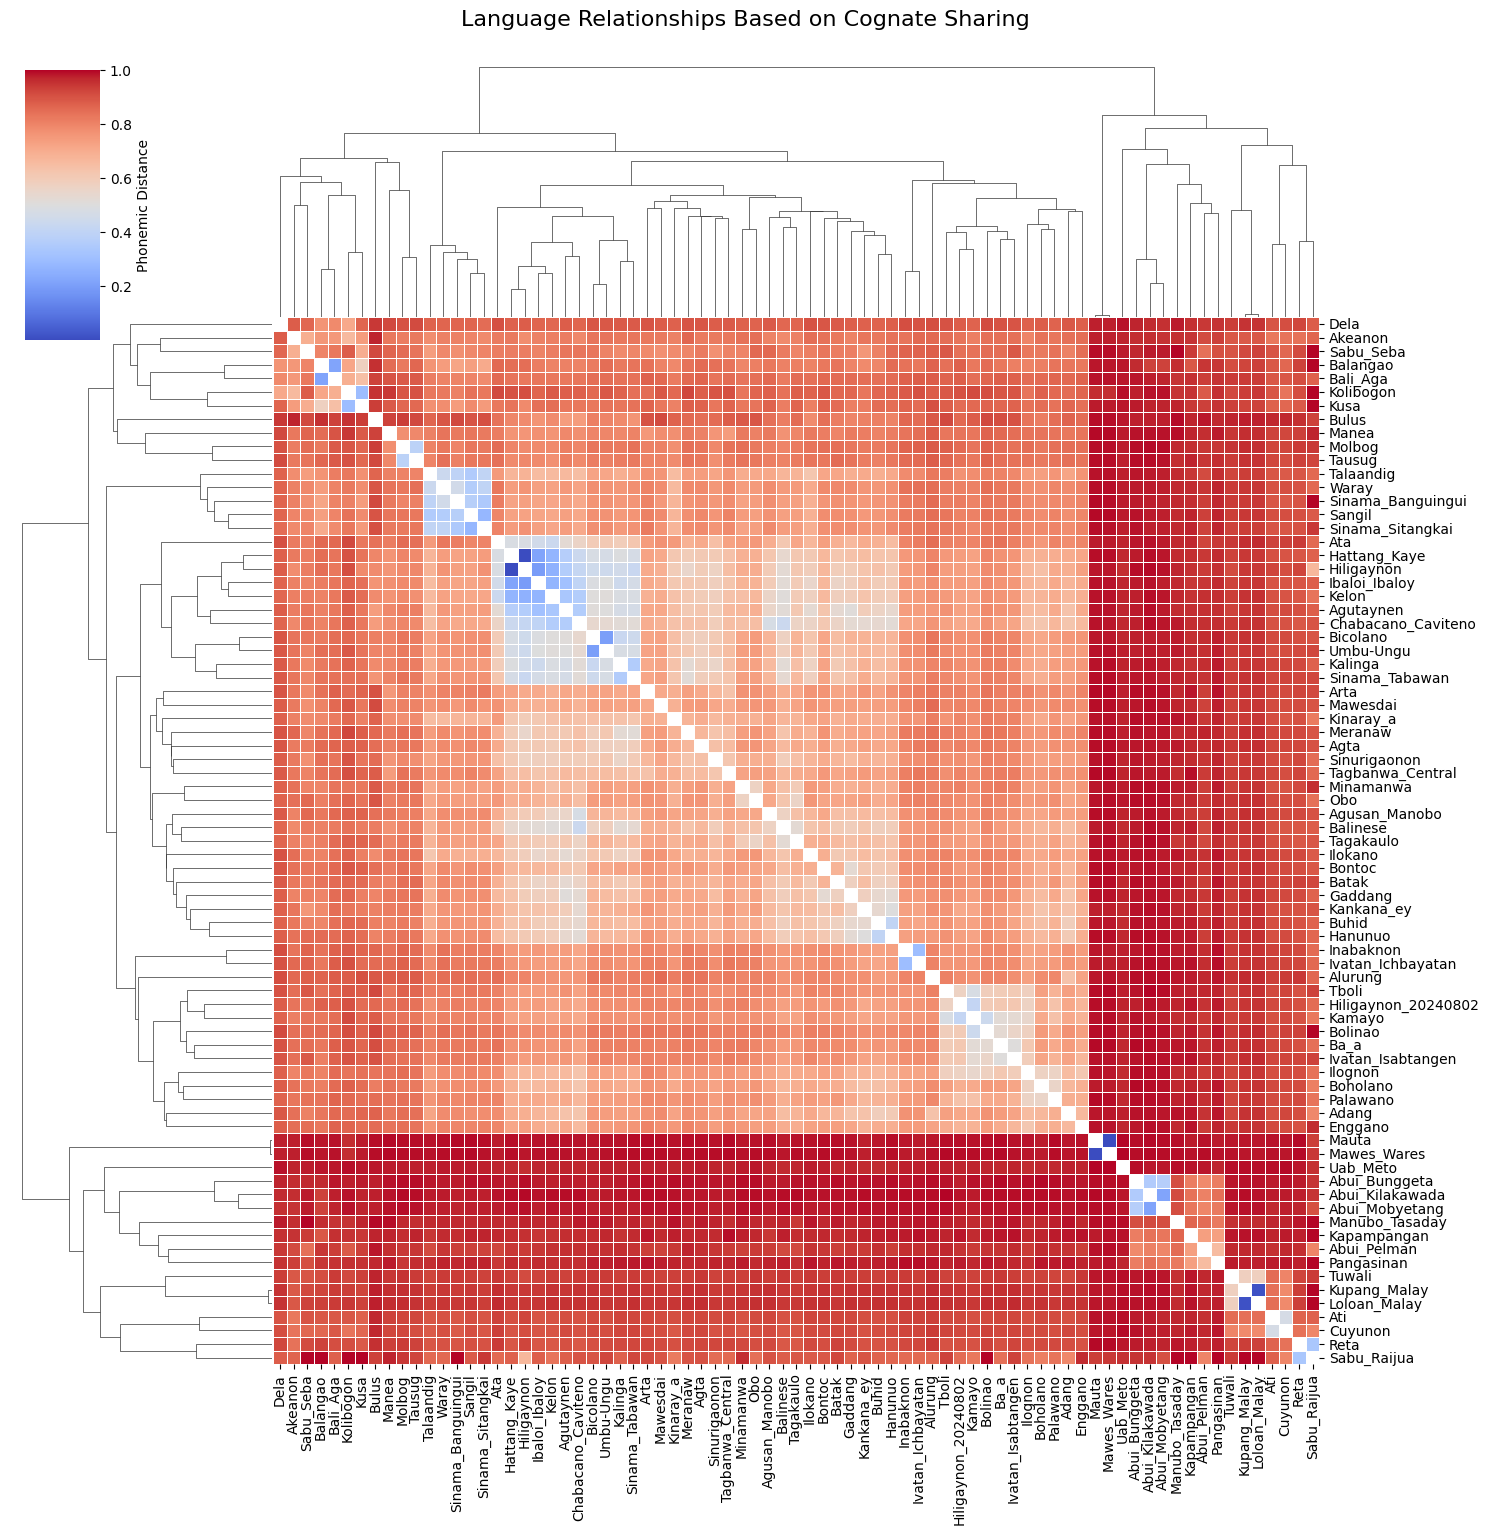

In [28]:
visualize_distance_matrix(results_folder_name,dist_matrix=OCSEAN_processed_distances, png_filename='CognateSharingHeatmap.png', dpi=999)

In [94]:
def perform_pca_analysis(results_folder_name,dist_matrix, pca_components=15, dpi=999):
    """Perform Principal Component Analysis on distance matrix and export plots.

    Args:
        dist_matrix (pd.DataFrame): The distance matrix to perform PCA on.
        pca_components (int): Number of principal components to calculate.
        results_folder_name (str): The name of the folder where results (including plots) will be saved.
                                   This folder is assumed to exist and be managed by calling code.
        dpi (int): The resolution in dots per inch for saving the plots.
    """
    print("\n" + "=" * 50)
    print("STEP 11: Principal Component Analysis")
    print("=" * 50)

    # Ensure the results folder exists (though assumed handled by calling code,
    # a defensive check here doesn't hurt if this function might be called independently).
    if not os.path.exists(results_folder_name):
        os.makedirs(results_folder_name)
        print(f"Folder '{results_folder_name}' created for PCA results.")

    # Prepare data for PCA
    X = dist_matrix.values
    X_scaled = StandardScaler().fit_transform(X)

    # Perform PCA
    pca = PCA(n_components=pca_components)
    components = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_

    print(f"PCA completed with {pca_components} components")
    print(f"Total explained variance: {explained_variance.sum():.2%}")
    print(f"First component explain: {explained_variance[:1].sum():.2%}")
    print(f"First 2 components explain: {explained_variance[:2].sum():.2%}")
    print(f"First 3 components explain: {explained_variance[:3].sum():.2%}\n")

    # --- Plot and Export Elbow Plot ---
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, pca_components + 1), explained_variance, marker='o', linestyle='--')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Explained Variance (Elbow Plot)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    #plt.show()

    # Define filename and construct full path for elbow plot
    elbow_plot_filename = "pca_elbow_plot.png"
    full_elbow_plot_path = os.path.join(results_folder_name, elbow_plot_filename)

    try:
        plt.savefig(full_elbow_plot_path, dpi=dpi, bbox_inches='tight')
        print(f"Elbow plot saved to: {full_elbow_plot_path}")
    except Exception as e:
        print(f"Error saving elbow plot: {e}")
    
    plt.show() 
    plt.close() # Close the plot to free up memory and prevent it from displaying unnecessarily

    print("\n")

    # --- Create and Export PCA Scatter Plot (PC1 vs PC2) ---
    plt.figure(figsize=(20, 8))
    for i, lang in enumerate(dist_matrix.index):
        x, y = components[i, 0], components[i, 1]  # PC1 vs PC2
        plt.scatter(x, y, s=50, alpha=0.7)
        plt.annotate(lang, (x, y), xytext=(5, 5), textcoords='offset points',
                     fontsize=8, ha='left')

    plt.title("PCA of Phonemic Distance Matrix (PC1 vs PC2)", fontsize=14)
    plt.xlabel(f"PC1 ({explained_variance[0]:.1%} variance)")
    plt.ylabel(f"PC2 ({explained_variance[1]:.1%} variance)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

   # plt.show()

    # Define filename and construct full path for PCA scatter plot
    pca_scatter_plot_filename = "pca_distance_matrix_scatter.png"
    full_pca_scatter_plot_path = os.path.join(results_folder_name, pca_scatter_plot_filename)

    try:
        plt.savefig(full_pca_scatter_plot_path, dpi=dpi, bbox_inches='tight')
        print(f"PCA scatter plot saved to: {full_pca_scatter_plot_path}")
    except Exception as e:
        print(f"Error saving PCA scatter plot: {e}")
    plt.show() 
    plt.close() # Close the plot after saving

    return pca, components



STEP 11: Principal Component Analysis
PCA completed with 15 components
Total explained variance: 80.76%
First component explain: 40.40%
First 2 components explain: 47.00%
First 3 components explain: 53.18%

Elbow plot saved to: Pipeline results/pca_elbow_plot.png


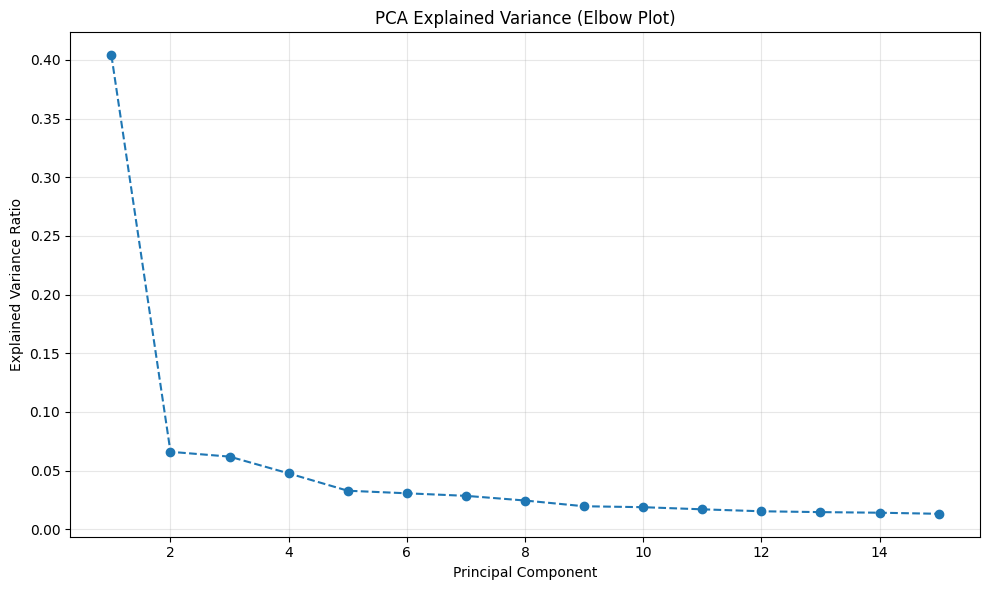



PCA scatter plot saved to: Pipeline results/pca_distance_matrix_scatter.png


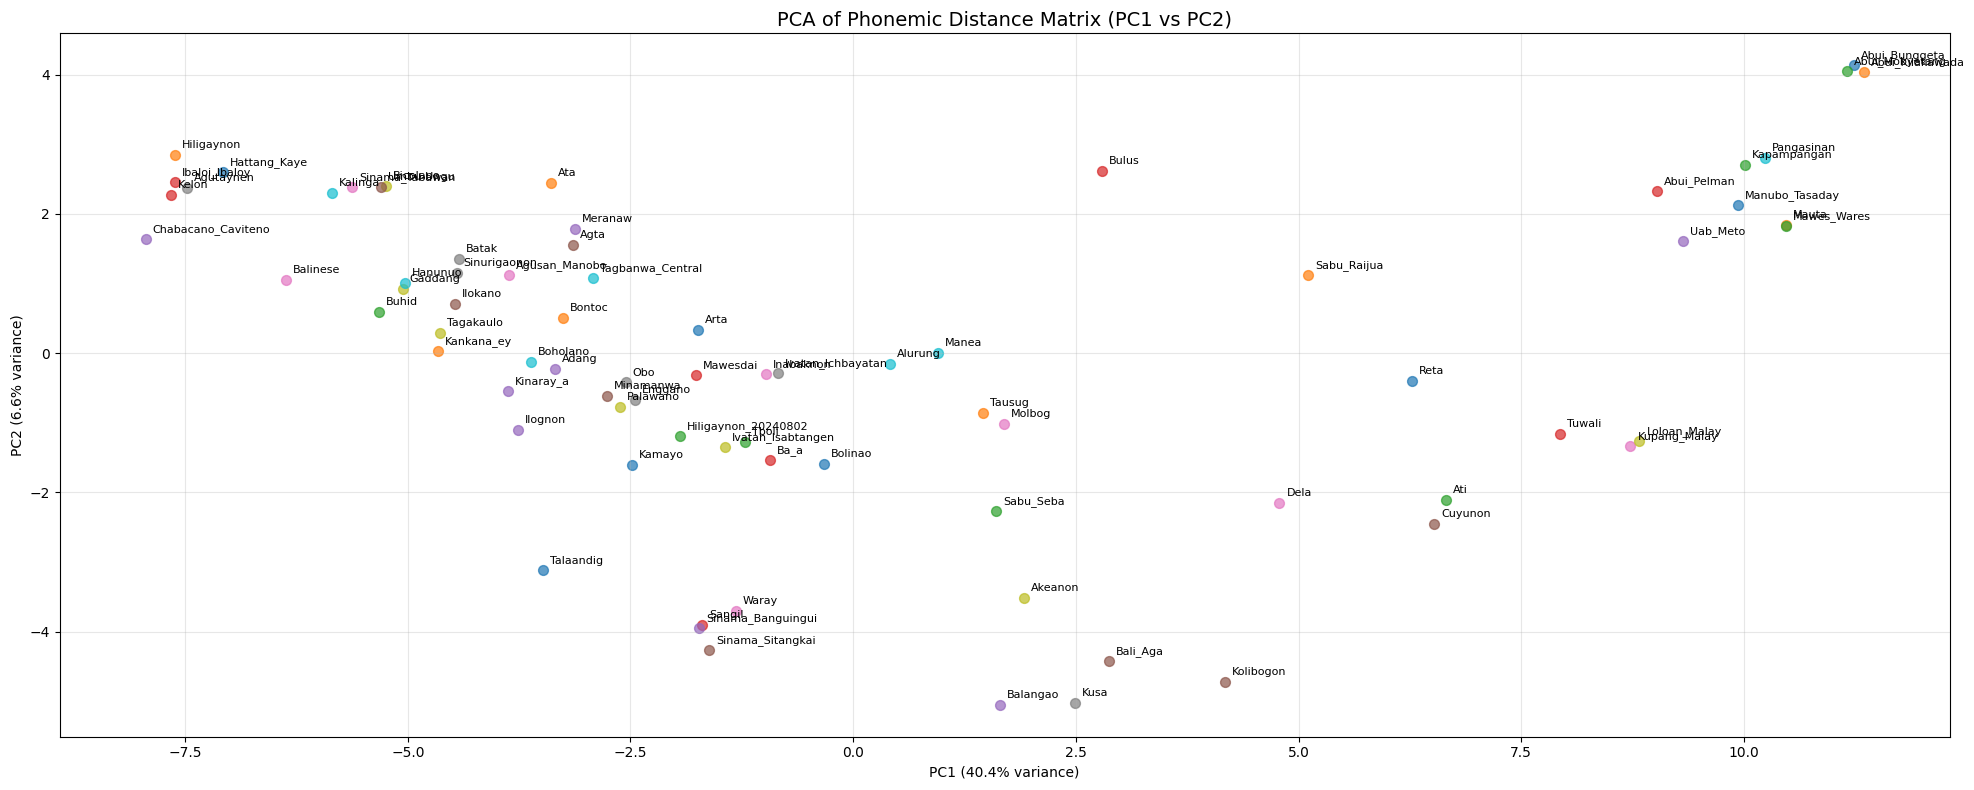

In [46]:
pca_results, pca_components = perform_pca_analysis(results_folder_name,dist_matrix=OCSEAN_processed_distances, pca_components=15)

In [122]:
def export_results_to_cldf(results_folder_name,alignments):
    """Export results to CLDF format for interoperability, saving within a specified results folder.

    Args:
        alignments: The alignments object to be exported to CLDF.
        results_folder_name (str): The name of the main results folder (e.g., "Pipeline results").
                                   The CLDF output will be saved in a subfolder within this.
    """
    print("\n" + "=" * 50)
    print("STEP 13: Exporting to CLDF format")
    print("=" * 50)

    try:
        # Define the name of the CLDF output subfolder
        cldf_subfolder_name = 'ocsean-cldf-output'

        # Construct the full path for the CLDF output folder
        # This will create a path like 'Pipeline results/ocsean-cldf-output'
        full_cldf_path = os.path.join(results_folder_name, cldf_subfolder_name)

        # Check if the folder exists, if not, create it, and provide specific feedback
        if not os.path.exists(full_cldf_path):
            os.makedirs(full_cldf_path)
            print(f"Folder '{full_cldf_path}' created successfully.")
        else:
            print(f"Folder '{full_cldf_path}' already exists. Using existing folder.")

        # Export to CLDF format
        # Assuming 'to_cldf' function is available from your environment.
        # It should take the full path to the desired output directory.
        to_cldf(alignments, path=full_cldf_path)
        print(f"Results exported to CLDF format in: {full_cldf_path}/")

    except Exception as e:
        print(f"CLDF export encountered an issue: {e}")
        print("CLDF export completed but file output failed.")

In [35]:
export_results_to_cldf(results_folder_name,alignments=OCSEAN_processed_alignments)


STEP 13: Exporting to CLDF format
Folder 'Pipeline results/ocsean-cldf-output' created successfully.
Results exported to CLDF format in: Pipeline results/ocsean-cldf-output/


# Analysis by semantic field

The easiest way to perform an analysis for each semantic field is to separate the input files by them.


In [104]:
# Construct the full path to the output file
inputdata_file_name = 'OCSEAN_processed_joineddata_semantic.tsv'
inputdata_file_path = os.path.join(results_folder_name, inputdata_file_name)
data_pd=pd.read_table(inputdata_file_path)
semantic_pd=data_pd[['Semantic_Field']].drop_duplicates().dropna()
semantic_pd.to_excel("semantic_field_list.xlsx")
semanticfields=semantic_pd['Semantic_Field'].tolist()

In [81]:
for field in semanticfields:
    semantic_folder_name = os.path.join('Pipeline results','Semantic',''.join(['semantic_field_',field]))
    semantic_data=data_pd[data_pd['Semantic_Field']==field]
    if not os.path.exists(semantic_folder_name):
        os.makedirs(semantic_folder_name)
    datafile=os.path.join('Pipeline results','Semantic',''.join(['semantic_field_',field]),'OCSEAN_processed_joineddata_semantic.tsv')
    print(datafile)
    semantic_data.to_csv(datafile, sep='\t', index=False) # index=False prevents writing DataFrame index to Excel

Pipeline results/Semantic/semantic_field_The physical world/OCSEAN_processed_joineddata_semantic.tsv
Pipeline results/Semantic/semantic_field_Spatial relations/OCSEAN_processed_joineddata_semantic.tsv
Pipeline results/Semantic/semantic_field_Time/OCSEAN_processed_joineddata_semantic.tsv
Pipeline results/Semantic/semantic_field_Social and political relations/OCSEAN_processed_joineddata_semantic.tsv
Pipeline results/Semantic/semantic_field_Agriculture and vegetation/OCSEAN_processed_joineddata_semantic.tsv
Pipeline results/Semantic/semantic_field_Motion/OCSEAN_processed_joineddata_semantic.tsv
Pipeline results/Semantic/semantic_field_Basic actions and technology/OCSEAN_processed_joineddata_semantic.tsv
Pipeline results/Semantic/semantic_field_Warfare and hunting/OCSEAN_processed_joineddata_semantic.tsv
Pipeline results/Semantic/semantic_field_Food and drink/OCSEAN_processed_joineddata_semantic.tsv
Pipeline results/Semantic/semantic_field_Clothing and grooming/OCSEAN_processed_joineddata_

In [144]:
cognate_threshold = .55
export_filename='detect_cognates_function_results'
for field in semanticfields:
    semantic_folder_name = os.path.join('Pipeline results','Semantic',''.join(['semantic_field_',field]))
    print(field)
    ## Load the data
    lexstat_object = load_and_validate_data(semantic_folder_name, joineddata_filename='OCSEAN_processed_joineddata_semantic.tsv')
    ## Learn synonyms
    synonyms_results = analyze_data_coverage(lexstat_object=lexstat_object)
    ## Detect cognates
    cognates_detected = detect_cognates(semantic_folder_name,lexstat_object, 
                                        cognate_threshold=cognate_threshold, export_filename=export_filename, verbose=False)
    ## Compute cognat overlaps
    compute_cognate_overlaps(results_folder_name)
    
    ## Compute distances
    OCSEAN_processed_alignments, OCSEAN_processed_distances = perform_alignment_and_process_distances(semantic_folder_name,
                                                                                                      filename=export_filename, 
                                                                                                      align_method='library')
    # Export Distance Matrix
    OCSEAN_processed_distances.to_csv(os.path.join(semantic_folder_name, 'OCSEAN_processed_distance_matrix.csv'))
    adjacency_matrix_results, scaled_adjacency_matrix, adj_scaled_adjacency_matrix = create_and_normalize_cognate_adjacency_matrix(semantic_folder_name,
                                                                                                                                   cognates_detected_results=cognates_detected, 
                                                                                                                                   OUTPUT_PREFIX='OCSEAN_processed')

2025-07-01 14:40:51,333 [INFO] No obvious errors found in the data.


The physical world
STEP 1: Loading and validating wordlist data
Loaded wordlist with 5933 entries

LexStat object created successfully

Sample data (first 4 entries):
----  ------  -------------  ------  ------------------  ----------------------  ------------  ----  ----  -  ------------------------------------  ---------------------  -
sun   wariy   Abui_Bunggeta  wariy   The physical world  ['w', 'a', 'r', 'iy']   [6, 7, 5, 7]  AXBZ  WARI  1  ['1.W.C', '1.A.V', '1.R.C', '1.I.V']  [2.0, 1.5, 1.75, 0.8]  0
moon  ʔuya    Abui_Bunggeta  ʔuya    The physical world  ['ʔ', 'uya']            [1, 7]        AX    HY    1  ['1.H.C', '1.Y.V']                    [2.0, 1.5]             0
star  furiy   Abui_Bunggeta  furiy   The physical world  ['f', 'u', 'r', 'iy']   [3, 7, 5, 7]  AXBZ  BYRI  1  ['1.B.C', '1.Y.V', '1.R.C', '1.I.V']  [2.0, 1.5, 1.75, 0.8]  0
sky   ʔadiiy  Abui_Bunggeta  ʔadiiy  The physical world  ['ʔ', 'a', 'd', 'iiy']  [1, 7, 1, 7]  AXBZ  HATI  1  ['1.H.C', '1.A.V', '1.T.C', '1.

Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-07-01 14:43:33,596 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_The physical world/detect_cognates_function_results.tsv>.                                          


Cognate results saved to: Pipeline results/Semantic/semantic_field_The physical world/detect_cognates_function_results
Cognate detection completed successfully!


2025-07-01 14:43:35,351 [INFO] No obvious errors found in the data.



STEP 5: Performing sequence alignment and calculating distances
Aligning sequences...
Calculating distance matrix...


2025-07-01 14:43:43,297 [INFO] Successfully calculated dst.
2025-07-01 14:43:43,300 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_The physical world/OCSEAN_processed_distances.dst>.



Final dist_matrix shape: (77, 77)
Final dist_matrix:
Column names: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Alurung']...
Matrix is symmetric: True



2025-07-01 14:43:43,859 [INFO] No obvious errors found in the data.



STEP 8: Creating cognate adjacency matrix

Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame using raw data: No raw data attribute found, attempting alternative conversion.

Attempting alternative conversion method (iterating indices)...
Successfully created DataFrame from indices with 5933 rows
Cleaned DataFrame shape: (5933, 4)
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']

Found 77 languages: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang']...

Computing cognate sharing patterns...
File 'OCSEAN_processed_cognate_adjacency_matrix_raw.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_The physical world' folder.
Matrix shape: (77, 77)

Sample of shared cognates between first 3 languages:

                 Abui_Bunggeta  Abui_Kilakawada  Abui_Mobyetang
Abui_Bunggeta               49               37              32
Abui_Kilakawada             37               44              31
Abui_Mobyetan

Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-07-01 14:45:58,677 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Spatial relations/detect_cognates_function_results.tsv>.                                           


Cognate results saved to: Pipeline results/Semantic/semantic_field_Spatial relations/detect_cognates_function_results
Cognate detection completed successfully!

STEP 5: Performing sequence alignment and calculating distances


2025-07-01 14:46:02,899 [INFO] No obvious errors found in the data.


Aligning sequences...
Calculating distance matrix...


2025-07-01 14:46:07,926 [INFO] Successfully calculated dst.
2025-07-01 14:46:07,930 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Spatial relations/OCSEAN_processed_distances.dst>.



Final dist_matrix shape: (72, 72)
Final dist_matrix:
Column names: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Alurung']...
Matrix is symmetric: True


STEP 8: Creating cognate adjacency matrix

Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame using raw data: No raw data attribute found, attempting alternative conversion.

Attempting alternative conversion method (iterating indices)...
Successfully created DataFrame from indices with 4040 rows
Cleaned DataFrame shape: (4040, 4)
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']

Found 72 languages: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang']...

Computing cognate sharing patterns...


2025-07-01 14:46:08,245 [INFO] No obvious errors found in the data.


File 'OCSEAN_processed_cognate_adjacency_matrix_raw.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Spatial relations' folder.
Matrix shape: (72, 72)

Sample of shared cognates between first 3 languages:

                 Abui_Bunggeta  Abui_Kilakawada  Abui_Mobyetang
Abui_Bunggeta               45               27              28
Abui_Kilakawada             27               34              24
Abui_Mobyetang              28               24              33

STEP 9: Normalizing adjacency matrix
File 'OCSEAN_processed_cognate_adjacency_matrix_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Spatial relations' folder.
File 'OCSEAN_processed_cognate_adjacency_matrix_adjusted_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Spatial relations' folder.
Normalization completed using log-transform and standardization

Complete
Time
STEP 1: Loading and validating wordlist data
Loaded wordlist with 2328 entries

L

Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-07-01 14:48:05,344 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Time/detect_cognates_function_results.tsv>.                                                        


Cognate results saved to: Pipeline results/Semantic/semantic_field_Time/detect_cognates_function_results
Cognate detection completed successfully!


2025-07-01 14:48:06,913 [INFO] No obvious errors found in the data.



STEP 5: Performing sequence alignment and calculating distances
Aligning sequences...


2025-07-01 14:48:09,372 [INFO] Successfully calculated dst.
2025-07-01 14:48:09,374 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Time/OCSEAN_processed_distances.dst>.


Calculating distance matrix...

Final dist_matrix shape: (72, 72)
Final dist_matrix:
Column names: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Alurung']...
Matrix is symmetric: True


STEP 8: Creating cognate adjacency matrix

Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame using raw data: No raw data attribute found, attempting alternative conversion.

Attempting alternative conversion method (iterating indices)...
Successfully created DataFrame from indices with 2328 rows
Cleaned DataFrame shape: (2328, 4)
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']

Found 72 languages: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang']...

Computing cognate sharing patterns...


2025-07-01 14:48:09,526 [INFO] No obvious errors found in the data.


File 'OCSEAN_processed_cognate_adjacency_matrix_raw.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Time' folder.
Matrix shape: (72, 72)

Sample of shared cognates between first 3 languages:

                 Abui_Bunggeta  Abui_Kilakawada  Abui_Mobyetang
Abui_Bunggeta               23               12              10
Abui_Kilakawada             12               16               7
Abui_Mobyetang              10                7              16

STEP 9: Normalizing adjacency matrix
File 'OCSEAN_processed_cognate_adjacency_matrix_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Time' folder.
File 'OCSEAN_processed_cognate_adjacency_matrix_adjusted_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Time' folder.
Normalization completed using log-transform and standardization

Complete
Social and political relations
STEP 1: Loading and validating wordlist data
Loaded wordlist with 1167 entries

LexStat object

Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-07-01 14:48:48,325 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Social and political relations/detect_cognates_function_results.tsv>.                              


Cognate results saved to: Pipeline results/Semantic/semantic_field_Social and political relations/detect_cognates_function_results
Cognate detection completed successfully!


2025-07-01 14:48:49,647 [INFO] No obvious errors found in the data.



STEP 5: Performing sequence alignment and calculating distances
Aligning sequences...


2025-07-01 14:48:50,937 [ERROR] Zero-division error encountered in 'Abui_Bunggeta' and 'Bali_Aga'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: division by zero
2025-07-01 14:48:50,942 [ERROR] Zero-division error encountered in 'Abui_Kilakawada' and 'Bali_Aga'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: division by zero
2025-07-01 14:48:50,945 [ERROR] Zero-division error encountered in 'Abui_Mobyetang' and 'Bali_Aga'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1

Calculating distance matrix...

Final dist_matrix shape: (77, 77)
Final dist_matrix:
Column names: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Alurung']...
Matrix is symmetric: True



2025-07-01 14:48:51,353 [INFO] No obvious errors found in the data.



STEP 8: Creating cognate adjacency matrix

Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame using raw data: No raw data attribute found, attempting alternative conversion.

Attempting alternative conversion method (iterating indices)...
Successfully created DataFrame from indices with 1167 rows
Cleaned DataFrame shape: (1167, 4)
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']

Found 77 languages: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang']...

Computing cognate sharing patterns...
File 'OCSEAN_processed_cognate_adjacency_matrix_raw.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Social and political relations' folder.
Matrix shape: (77, 77)

Sample of shared cognates between first 3 languages:

                 Abui_Bunggeta  Abui_Kilakawada  Abui_Mobyetang
Abui_Bunggeta               24               11               9
Abui_Kilakawada             11               19               6
A

Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-07-01 14:51:02,225 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Agriculture and vegetation/detect_cognates_function_results.tsv>.                                  


Cognate results saved to: Pipeline results/Semantic/semantic_field_Agriculture and vegetation/detect_cognates_function_results
Cognate detection completed successfully!


2025-07-01 14:51:03,645 [INFO] No obvious errors found in the data.



STEP 5: Performing sequence alignment and calculating distances
Aligning sequences...
Calculating distance matrix...


2025-07-01 14:51:07,639 [ERROR] Zero-division error encountered in 'Hiligaynon_20240802' and 'Loloan_Malay'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: division by zero
2025-07-01 14:51:07,705 [ERROR] Zero-division error encountered in 'Kupang_Malay' and 'Loloan_Malay'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: division by zero
2025-07-01 14:51:07,707 [ERROR] Zero-division error encountered in 'Kupang_Malay' and 'Sabu_Seba'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
  


Final dist_matrix shape: (77, 77)
Final dist_matrix:
Column names: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Alurung']...
Matrix is symmetric: True


STEP 8: Creating cognate adjacency matrix

Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame using raw data: No raw data attribute found, attempting alternative conversion.

Attempting alternative conversion method (iterating indices)...
Successfully created DataFrame from indices with 5730 rows
Cleaned DataFrame shape: (5730, 4)
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']

Found 77 languages: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang']...

Computing cognate sharing patterns...
File 'OCSEAN_processed_cognate_adjacency_matrix_raw.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Agriculture and vegetation' folder.
Matrix shape: (77, 77)

Sample of shar

2025-07-01 14:51:08,104 [INFO] No obvious errors found in the data.


File 'OCSEAN_processed_cognate_adjacency_matrix_adjusted_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Agriculture and vegetation' folder.
Normalization completed using log-transform and standardization

Complete
Motion
STEP 1: Loading and validating wordlist data
Loaded wordlist with 3812 entries

LexStat object created successfully

Sample data (first 4 entries):
---------------  -------------  -------------  ------------  ------  ----------------------------------------------------  ------------------------------  ----------  ----------  -  ------------------------------------------------------------------------------------------  ------------------------------------------------------  -
road             jalee.kidiing  Abui_Bunggeta  jaleekidiing  Motion  ['j', 'a', 'l', 'ee', 'k', 'i', 'd', 'ii', 'n', 'g']  [6, 7, 5, 7, 1, 7, 1, 7, 4, 1]  AXBYBYBYLN  JALEKITINK  1  ['1.J.C', '1.A.V', '1.L.C', '1.E.V', '1.K.C', '1.I.V', '1.T.C', '1.I.V', '1.N.c', '1.

Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-07-01 14:53:06,863 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Motion/detect_cognates_function_results.tsv>.                                                      


Cognate results saved to: Pipeline results/Semantic/semantic_field_Motion/detect_cognates_function_results
Cognate detection completed successfully!


2025-07-01 14:53:08,329 [INFO] No obvious errors found in the data.



STEP 5: Performing sequence alignment and calculating distances
Aligning sequences...
Calculating distance matrix...


2025-07-01 14:53:14,022 [INFO] Successfully calculated dst.
2025-07-01 14:53:14,026 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Motion/OCSEAN_processed_distances.dst>.



Final dist_matrix shape: (74, 74)
Final dist_matrix:
Column names: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Alurung']...
Matrix is symmetric: True


STEP 8: Creating cognate adjacency matrix

Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame using raw data: No raw data attribute found, attempting alternative conversion.

Attempting alternative conversion method (iterating indices)...
Successfully created DataFrame from indices with 3812 rows
Cleaned DataFrame shape: (3812, 4)
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']

Found 74 languages: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang']...

Computing cognate sharing patterns...
File 'OCSEAN_processed_cognate_adjacency_matrix_raw.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Motion' folder.
Matrix shape: (74, 74)

Sample of shared cognates between 

2025-07-01 14:53:14,292 [INFO] No obvious errors found in the data.


LexStat object created successfully

Sample data (first 4 entries):
----  ----------  -------------  ---------  ----------------------------  -----------------------------------------  ------------------------  --------  --------  -  ------------------------------------------------------------------------  ------------------------------------------  -
boat  ʔe.kidiing  Abui_Bunggeta  ʔekidiing  Basic actions and technology  ['ʔ', 'e', 'k', 'i', 'd', 'ii', 'n', 'g']  [1, 7, 1, 7, 1, 7, 4, 1]  AXBYBYLN  HEKITINK  1  ['1.H.C', '1.E.V', '1.K.C', '1.I.V', '1.T.C', '1.I.V', '1.N.c', '1.K.c']  [2.0, 1.5, 1.75, 1.3, 1.75, 1.3, 1.1, 0.8]  0
boat  ʔeʔ         Abui_Bunggeta  ʔeʔ        Basic actions and technology  ['ʔ', 'e', 'ʔ']                            [1, 7, 1]                 AXN       HEH       1  ['1.H.C', '1.E.V', '1.H.c']                                               [2.0, 1.5, 0.8]                             0
rope  tila        Abui_Bunggeta  tila       Basic actions and technology  

Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-07-01 14:55:03,322 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Basic actions and technology/detect_cognates_function_results.tsv>.                                


Cognate results saved to: Pipeline results/Semantic/semantic_field_Basic actions and technology/detect_cognates_function_results
Cognate detection completed successfully!


2025-07-01 14:55:04,776 [INFO] No obvious errors found in the data.



STEP 5: Performing sequence alignment and calculating distances
Aligning sequences...
Calculating distance matrix...


2025-07-01 14:55:08,611 [INFO] Successfully calculated dst.
2025-07-01 14:55:08,623 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Basic actions and technology/OCSEAN_processed_distances.dst>.



Final dist_matrix shape: (74, 74)
Final dist_matrix:
Column names: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Alurung']...
Matrix is symmetric: True


STEP 8: Creating cognate adjacency matrix

Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame using raw data: No raw data attribute found, attempting alternative conversion.

Attempting alternative conversion method (iterating indices)...
Successfully created DataFrame from indices with 4759 rows
Cleaned DataFrame shape: (4759, 4)
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']

Found 74 languages: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang']...

Computing cognate sharing patterns...


2025-07-01 14:55:08,894 [INFO] No obvious errors found in the data.


File 'OCSEAN_processed_cognate_adjacency_matrix_raw.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Basic actions and technology' folder.
Matrix shape: (74, 74)

Sample of shared cognates between first 3 languages:

                 Abui_Bunggeta  Abui_Kilakawada  Abui_Mobyetang
Abui_Bunggeta               30               17              14
Abui_Kilakawada             17               22              13
Abui_Mobyetang              14               13              22

STEP 9: Normalizing adjacency matrix
File 'OCSEAN_processed_cognate_adjacency_matrix_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Basic actions and technology' folder.
File 'OCSEAN_processed_cognate_adjacency_matrix_adjusted_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Basic actions and technology' folder.
Normalization completed using log-transform and standardization

Complete
Warfare and hunting
STEP 1: Loading and validating wo

Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-07-01 14:55:57,361 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Warfare and hunting/detect_cognates_function_results.tsv>.                                         


Cognate results saved to: Pipeline results/Semantic/semantic_field_Warfare and hunting/detect_cognates_function_results
Cognate detection completed successfully!


2025-07-01 14:55:58,740 [INFO] No obvious errors found in the data.



STEP 5: Performing sequence alignment and calculating distances
Aligning sequences...


2025-07-01 14:56:00,531 [ERROR] Zero-division error encountered in 'Enggano' and 'Kolibogon'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: division by zero
2025-07-01 14:56:00,556 [ERROR] Zero-division error encountered in 'Kolibogon' and 'Sinama_Banguingui'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: division by zero
2025-07-01 14:56:00,556 [ERROR] Zero-division error encountered in 'Kolibogon' and 'Tagakaulo'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - sha

Calculating distance matrix...

Final dist_matrix shape: (67, 67)
Final dist_matrix:
Column names: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Arta', 'Ata']...
Matrix is symmetric: True


STEP 8: Creating cognate adjacency matrix

Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame using raw data: No raw data attribute found, attempting alternative conversion.

Attempting alternative conversion method (iterating indices)...


2025-07-01 14:56:00,873 [INFO] No obvious errors found in the data.


Successfully created DataFrame from indices with 1401 rows
Cleaned DataFrame shape: (1401, 4)
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']

Found 67 languages: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Agta']...

Computing cognate sharing patterns...
File 'OCSEAN_processed_cognate_adjacency_matrix_raw.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Warfare and hunting' folder.
Matrix shape: (67, 67)

Sample of shared cognates between first 3 languages:

                 Abui_Bunggeta  Abui_Kilakawada  Abui_Mobyetang
Abui_Bunggeta               18                6               4
Abui_Kilakawada              6               14               5
Abui_Mobyetang               4                5              16

STEP 9: Normalizing adjacency matrix
File 'OCSEAN_processed_cognate_adjacency_matrix_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Warfare and hunting' folder.
File 'OCSEAN_processed_c

Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-07-01 14:58:17,229 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Food and drink/detect_cognates_function_results.tsv>.                                              


Cognate results saved to: Pipeline results/Semantic/semantic_field_Food and drink/detect_cognates_function_results
Cognate detection completed successfully!


2025-07-01 14:58:18,662 [INFO] No obvious errors found in the data.



STEP 5: Performing sequence alignment and calculating distances
Aligning sequences...
Calculating distance matrix...


2025-07-01 14:58:23,648 [ERROR] Zero-division error encountered in 'Loloan_Malay' and 'Sabu_Seba'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: division by zero
2025-07-01 14:58:23,697 [INFO] Successfully calculated dst.
2025-07-01 14:58:23,717 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Food and drink/OCSEAN_processed_distances.dst>.



Final dist_matrix shape: (75, 75)
Final dist_matrix:
Column names: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Alurung']...
Matrix is symmetric: True


STEP 8: Creating cognate adjacency matrix

Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame using raw data: No raw data attribute found, attempting alternative conversion.

Attempting alternative conversion method (iterating indices)...
Successfully created DataFrame from indices with 7704 rows
Cleaned DataFrame shape: (7704, 4)
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']

Found 75 languages: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang']...

Computing cognate sharing patterns...
File 'OCSEAN_processed_cognate_adjacency_matrix_raw.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Food and drink' folder.
Matrix shape: (75, 75)

Sample of shared cognates 

2025-07-01 14:58:23,984 [INFO] No obvious errors found in the data.


File 'OCSEAN_processed_cognate_adjacency_matrix_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Food and drink' folder.
File 'OCSEAN_processed_cognate_adjacency_matrix_adjusted_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Food and drink' folder.
Normalization completed using log-transform and standardization

Complete
Clothing and grooming
STEP 1: Loading and validating wordlist data
Loaded wordlist with 2409 entries

LexStat object created successfully

Sample data (first 4 entries):
------  -----  -------------  -----  ---------------------  ---------------------  ------------  ----  ----  -  ------------------------------------  ---------------------  -
comb    keeti  Abui_Bunggeta  keeti  Clothing and grooming  ['k', 'ee', 't', 'i']  [1, 7, 1, 7]  AXBZ  KETI  1  ['1.K.C', '1.E.V', '1.T.C', '1.I.V']  [2.0, 1.5, 1.75, 0.8]  0
comb    keeti  Abui_Bunggeta  keeti  Clothing and grooming  ['k', 'ee', 't', 'i']  [1, 7, 1, 7]

Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-07-01 14:59:07,560 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Clothing and grooming/detect_cognates_function_results.tsv>.                                       


Cognate results saved to: Pipeline results/Semantic/semantic_field_Clothing and grooming/detect_cognates_function_results
Cognate detection completed successfully!


2025-07-01 14:59:09,048 [INFO] No obvious errors found in the data.



STEP 5: Performing sequence alignment and calculating distances
Aligning sequences...


2025-07-01 14:59:13,873 [ERROR] Zero-division error encountered in 'Adang' and 'Gaddang'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: division by zero
2025-07-01 14:59:13,876 [ERROR] Zero-division error encountered in 'Adang' and 'Kolibogon'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: division by zero
2025-07-01 14:59:13,877 [ERROR] Zero-division error encountered in 'Adang' and 'Tuwali'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.height - miss

Calculating distance matrix...

Final dist_matrix shape: (73, 73)
Final dist_matrix:
Column names: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Alurung']...
Matrix is symmetric: True


STEP 8: Creating cognate adjacency matrix

Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame using raw data: No raw data attribute found, attempting alternative conversion.

Attempting alternative conversion method (iterating indices)...
Successfully created DataFrame from indices with 2409 rows
Cleaned DataFrame shape: (2409, 4)
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']


2025-07-01 14:59:14,144 [INFO] No obvious errors found in the data.



Found 73 languages: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang']...

Computing cognate sharing patterns...
File 'OCSEAN_processed_cognate_adjacency_matrix_raw.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Clothing and grooming' folder.
Matrix shape: (73, 73)

Sample of shared cognates between first 3 languages:

                 Abui_Bunggeta  Abui_Kilakawada  Abui_Mobyetang
Abui_Bunggeta               16                4               7
Abui_Kilakawada              4               12               3
Abui_Mobyetang               7                3              12

STEP 9: Normalizing adjacency matrix
File 'OCSEAN_processed_cognate_adjacency_matrix_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Clothing and grooming' folder.
File 'OCSEAN_processed_cognate_adjacency_matrix_adjusted_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Clothing and grooming' folder.
Normal

Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-07-01 15:00:19,564 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_The house/detect_cognates_function_results.tsv>.                                                   


Cognate results saved to: Pipeline results/Semantic/semantic_field_The house/detect_cognates_function_results
Cognate detection completed successfully!


2025-07-01 15:00:20,861 [INFO] No obvious errors found in the data.



STEP 5: Performing sequence alignment and calculating distances
Aligning sequences...


2025-07-01 15:00:22,373 [ERROR] Zero-division error encountered in 'Adang' and 'Loloan_Malay'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: division by zero
2025-07-01 15:00:22,384 [ERROR] Zero-division error encountered in 'Alurung' and 'Loloan_Malay'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: division by zero
2025-07-01 15:00:22,438 [ERROR] Zero-division error encountered in 'Kelon' and 'Loloan_Malay'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (

Calculating distance matrix...

Final dist_matrix shape: (73, 73)
Final dist_matrix:
Column names: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Alurung']...
Matrix is symmetric: True


STEP 8: Creating cognate adjacency matrix

Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame using raw data: No raw data attribute found, attempting alternative conversion.

Attempting alternative conversion method (iterating indices)...
Successfully created DataFrame from indices with 1668 rows
Cleaned DataFrame shape: (1668, 4)
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']

Found 73 languages: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang']...

Computing cognate sharing patterns...


2025-07-01 15:00:22,655 [INFO] No obvious errors found in the data.


File 'OCSEAN_processed_cognate_adjacency_matrix_raw.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_The house' folder.
Matrix shape: (73, 73)

Sample of shared cognates between first 3 languages:

                 Abui_Bunggeta  Abui_Kilakawada  Abui_Mobyetang
Abui_Bunggeta               33               13              12
Abui_Kilakawada             13               21              10
Abui_Mobyetang              12               10              22

STEP 9: Normalizing adjacency matrix
File 'OCSEAN_processed_cognate_adjacency_matrix_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_The house' folder.
File 'OCSEAN_processed_cognate_adjacency_matrix_adjusted_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_The house' folder.
Normalization completed using log-transform and standardization

Complete
Religion and belief
STEP 1: Loading and validating wordlist data
Loaded wordlist with 973 entries

LexStat obj

Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-07-01 15:00:58,865 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Religion and belief/detect_cognates_function_results.tsv>.                                         


Cognate results saved to: Pipeline results/Semantic/semantic_field_Religion and belief/detect_cognates_function_results
Cognate detection completed successfully!


2025-07-01 15:01:00,109 [INFO] No obvious errors found in the data.



STEP 5: Performing sequence alignment and calculating distances
Aligning sequences...


2025-07-01 15:01:00,961 [ERROR] Zero-division error encountered in 'Abui_Bunggeta' and 'Agutaynen'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: division by zero
2025-07-01 15:01:00,962 [ERROR] Zero-division error encountered in 'Abui_Bunggeta' and 'Ata'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: division by zero
2025-07-01 15:01:00,963 [ERROR] Zero-division error encountered in 'Abui_Bunggeta' and 'Bontoc'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared

Calculating distance matrix...

Final dist_matrix shape: (67, 67)
Final dist_matrix:
Column names: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Arta', 'Ata']...
Matrix is symmetric: True


STEP 8: Creating cognate adjacency matrix

Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame using raw data: No raw data attribute found, attempting alternative conversion.

Attempting alternative conversion method (iterating indices)...
Successfully created DataFrame from indices with 973 rows
Cleaned DataFrame shape: (973, 4)
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']

Found 67 languages: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Agta']...

Computing cognate sharing patterns...
File 'OCSEAN_processed_cognate_adjacency_matrix_raw.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Religion and belief' folder.
Matrix shape: (67, 67)

2025-07-01 15:01:01,409 [INFO] No obvious errors found in the data.


Loaded wordlist with 11866 entries

LexStat object created successfully

Sample data (first 4 entries):
----  -------  -------------  -------  --------  -----------------------  ------------  ----  ----  -  ------------------------------------  ---------------------  -
milk  tuk      Abui_Bunggeta  tuk      The body  ['t', 'u', 'k']          [1, 7, 1]     AXN   TYK   1  ['1.T.C', '1.Y.V', '1.K.c']           [2.0, 1.5, 0.8]        0
milk  tuuk     Abui_Bunggeta  tuuk     The body  ['t', 'uu', 'k']         [1, 7, 1]     AXN   TYK   1  ['1.T.C', '1.Y.V', '1.K.c']           [2.0, 1.5, 0.8]        0
head  tiyeqai  Abui_Bunggeta  tiyeqai  The body  ['t', 'iye', 'q', 'ai']  [1, 7, 1, 7]  AXBZ  TIKA  1  ['1.T.C', '1.I.V', '1.K.C', '1.A.V']  [2.0, 1.5, 1.75, 0.8]  0
head  qai      Abui_Bunggeta  qai      The body  ['q', 'ai']              [1, 7]        AX    KA    1  ['1.K.C', '1.A.V']                    [2.0, 1.5]             0
----  -------  -------------  -------  --------  -----------------

Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-07-01 15:03:56,829 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_The body/detect_cognates_function_results.tsv>.                                                    


Cognate results saved to: Pipeline results/Semantic/semantic_field_The body/detect_cognates_function_results
Cognate detection completed successfully!

STEP 5: Performing sequence alignment and calculating distances


2025-07-01 15:03:58,417 [INFO] No obvious errors found in the data.


Aligning sequences...
Calculating distance matrix...


2025-07-01 15:04:14,101 [INFO] Successfully calculated dst.
2025-07-01 15:04:14,108 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_The body/OCSEAN_processed_distances.dst>.



Final dist_matrix shape: (75, 75)
Final dist_matrix:
Column names: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Alurung']...
Matrix is symmetric: True


STEP 8: Creating cognate adjacency matrix

Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame using raw data: No raw data attribute found, attempting alternative conversion.

Attempting alternative conversion method (iterating indices)...
Successfully created DataFrame from indices with 11866 rows
Cleaned DataFrame shape: (11866, 4)
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']

Found 75 languages: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang']...

Computing cognate sharing patterns...


2025-07-01 15:04:14,834 [INFO] No obvious errors found in the data.


File 'OCSEAN_processed_cognate_adjacency_matrix_raw.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_The body' folder.
Matrix shape: (75, 75)

Sample of shared cognates between first 3 languages:

                 Abui_Bunggeta  Abui_Kilakawada  Abui_Mobyetang
Abui_Bunggeta              109               75              68
Abui_Kilakawada             75               95              62
Abui_Mobyetang              68               62              91

STEP 9: Normalizing adjacency matrix
File 'OCSEAN_processed_cognate_adjacency_matrix_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_The body' folder.
File 'OCSEAN_processed_cognate_adjacency_matrix_adjusted_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_The body' folder.
Normalization completed using log-transform and standardization

Complete
Kinship
STEP 1: Loading and validating wordlist data
Loaded wordlist with 4164 entries

LexStat object created su

Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-07-01 15:06:56,532 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Kinship/detect_cognates_function_results.tsv>.                                                     


Cognate results saved to: Pipeline results/Semantic/semantic_field_Kinship/detect_cognates_function_results
Cognate detection completed successfully!


2025-07-01 15:06:58,381 [INFO] No obvious errors found in the data.



STEP 5: Performing sequence alignment and calculating distances
Aligning sequences...
Calculating distance matrix...


2025-07-01 15:07:06,329 [INFO] Successfully calculated dst.
2025-07-01 15:07:06,341 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Kinship/OCSEAN_processed_distances.dst>.



Final dist_matrix shape: (77, 77)
Final dist_matrix:
Column names: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Alurung']...
Matrix is symmetric: True


STEP 8: Creating cognate adjacency matrix

Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame using raw data: No raw data attribute found, attempting alternative conversion.

Attempting alternative conversion method (iterating indices)...
Successfully created DataFrame from indices with 4164 rows
Cleaned DataFrame shape: (4164, 4)
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']

Found 77 languages: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang']...

Computing cognate sharing patterns...


2025-07-01 15:07:06,670 [INFO] No obvious errors found in the data.


File 'OCSEAN_processed_cognate_adjacency_matrix_raw.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Kinship' folder.
Matrix shape: (77, 77)

Sample of shared cognates between first 3 languages:

                 Abui_Bunggeta  Abui_Kilakawada  Abui_Mobyetang
Abui_Bunggeta               36               19              22
Abui_Kilakawada             19               29              21
Abui_Mobyetang              22               21              29

STEP 9: Normalizing adjacency matrix
File 'OCSEAN_processed_cognate_adjacency_matrix_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Kinship' folder.
File 'OCSEAN_processed_cognate_adjacency_matrix_adjusted_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Kinship' folder.
Normalization completed using log-transform and standardization

Complete
Emotions and values
STEP 1: Loading and validating wordlist data
Loaded wordlist with 2914 entries

LexStat object c

Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-07-01 15:08:48,908 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Emotions and values/detect_cognates_function_results.tsv>.                                         


Cognate results saved to: Pipeline results/Semantic/semantic_field_Emotions and values/detect_cognates_function_results
Cognate detection completed successfully!


2025-07-01 15:08:50,249 [INFO] No obvious errors found in the data.



STEP 5: Performing sequence alignment and calculating distances
Aligning sequences...


2025-07-01 15:08:52,473 [ERROR] Zero-division error encountered in 'Abui_Bunggeta' and 'Ati'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: division by zero
2025-07-01 15:08:52,476 [ERROR] Zero-division error encountered in 'Abui_Bunggeta' and 'Hiligaynon_20240802'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: division by zero
2025-07-01 15:08:52,480 [ERROR] Zero-division error encountered in 'Abui_Kilakawada' and 'Ati'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1

Calculating distance matrix...

Final dist_matrix shape: (74, 74)
Final dist_matrix:
Column names: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Alurung']...
Matrix is symmetric: True



2025-07-01 15:08:52,815 [INFO] No obvious errors found in the data.



STEP 8: Creating cognate adjacency matrix

Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame using raw data: No raw data attribute found, attempting alternative conversion.

Attempting alternative conversion method (iterating indices)...
Successfully created DataFrame from indices with 2914 rows
Cleaned DataFrame shape: (2914, 4)
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']

Found 74 languages: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang']...

Computing cognate sharing patterns...
File 'OCSEAN_processed_cognate_adjacency_matrix_raw.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Emotions and values' folder.
Matrix shape: (74, 74)

Sample of shared cognates between first 3 languages:

                 Abui_Bunggeta  Abui_Kilakawada  Abui_Mobyetang
Abui_Bunggeta               20                6              10
Abui_Kilakawada              6               13               3
Abui_Mobyeta

Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-07-01 15:10:02,033 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Speech and language/detect_cognates_function_results.tsv>.                                         


Cognate results saved to: Pipeline results/Semantic/semantic_field_Speech and language/detect_cognates_function_results
Cognate detection completed successfully!


2025-07-01 15:10:03,496 [INFO] No obvious errors found in the data.



STEP 5: Performing sequence alignment and calculating distances
Aligning sequences...


2025-07-01 15:10:05,129 [INFO] Successfully calculated dst.
2025-07-01 15:10:05,132 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Speech and language/OCSEAN_processed_distances.dst>.


Calculating distance matrix...

Final dist_matrix shape: (71, 71)
Final dist_matrix:
Column names: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Alurung']...
Matrix is symmetric: True


STEP 8: Creating cognate adjacency matrix

Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame using raw data: No raw data attribute found, attempting alternative conversion.

Attempting alternative conversion method (iterating indices)...
Successfully created DataFrame from indices with 1698 rows
Cleaned DataFrame shape: (1698, 4)
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']

Found 71 languages: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang']...

Computing cognate sharing patterns...


2025-07-01 15:10:05,391 [INFO] No obvious errors found in the data.


File 'OCSEAN_processed_cognate_adjacency_matrix_raw.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Speech and language' folder.
Matrix shape: (71, 71)

Sample of shared cognates between first 3 languages:

                 Abui_Bunggeta  Abui_Kilakawada  Abui_Mobyetang
Abui_Bunggeta               19                9              12
Abui_Kilakawada              9               14               8
Abui_Mobyetang              12                8              14

STEP 9: Normalizing adjacency matrix
File 'OCSEAN_processed_cognate_adjacency_matrix_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Speech and language' folder.
File 'OCSEAN_processed_cognate_adjacency_matrix_adjusted_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Speech and language' folder.
Normalization completed using log-transform and standardization

Complete
Cognition
STEP 1: Loading and validating wordlist data
Loaded wordlist with 2207

Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-07-01 15:11:37,829 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Cognition/detect_cognates_function_results.tsv>.                                                   


Cognate results saved to: Pipeline results/Semantic/semantic_field_Cognition/detect_cognates_function_results
Cognate detection completed successfully!


2025-07-01 15:11:39,102 [INFO] No obvious errors found in the data.



STEP 5: Performing sequence alignment and calculating distances
Aligning sequences...


2025-07-01 15:11:41,864 [INFO] Successfully calculated dst.
2025-07-01 15:11:41,868 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Cognition/OCSEAN_processed_distances.dst>.


Calculating distance matrix...

Final dist_matrix shape: (72, 72)
Final dist_matrix:
Column names: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Alurung']...
Matrix is symmetric: True


STEP 8: Creating cognate adjacency matrix

Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame using raw data: No raw data attribute found, attempting alternative conversion.

Attempting alternative conversion method (iterating indices)...
Successfully created DataFrame from indices with 2207 rows
Cleaned DataFrame shape: (2207, 4)
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']

Found 72 languages: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang']...

Computing cognate sharing patterns...


2025-07-01 15:11:42,008 [INFO] No obvious errors found in the data.


File 'OCSEAN_processed_cognate_adjacency_matrix_raw.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Cognition' folder.
Matrix shape: (72, 72)

Sample of shared cognates between first 3 languages:

                 Abui_Bunggeta  Abui_Kilakawada  Abui_Mobyetang
Abui_Bunggeta               24               13               9
Abui_Kilakawada             13               16               8
Abui_Mobyetang               9                8              16

STEP 9: Normalizing adjacency matrix
File 'OCSEAN_processed_cognate_adjacency_matrix_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Cognition' folder.
File 'OCSEAN_processed_cognate_adjacency_matrix_adjusted_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Cognition' folder.
Normalization completed using log-transform and standardization

Complete
Miscellaneous function words
STEP 1: Loading and validating wordlist data
Loaded wordlist with 631 entries

Le

Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-07-01 15:11:51,168 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Miscellaneous function words/detect_cognates_function_results.tsv>.                                


Cognate results saved to: Pipeline results/Semantic/semantic_field_Miscellaneous function words/detect_cognates_function_results
Cognate detection completed successfully!


2025-07-01 15:11:52,959 [INFO] No obvious errors found in the data.



STEP 5: Performing sequence alignment and calculating distances
Aligning sequences...


2025-07-01 15:11:53,678 [ERROR] Zero-division error encountered in 'Loloan_Malay' and 'Tagakaulo'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: division by zero
2025-07-01 15:11:53,686 [INFO] Successfully calculated dst.
2025-07-01 15:11:53,689 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Miscellaneous function words/OCSEAN_processed_distances.dst>.
2025-07-01 15:11:53,847 [INFO] No obvious errors found in the data.


Calculating distance matrix...

Final dist_matrix shape: (72, 72)
Final dist_matrix:
Column names: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Alurung']...
Matrix is symmetric: True


STEP 8: Creating cognate adjacency matrix

Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame using raw data: No raw data attribute found, attempting alternative conversion.

Attempting alternative conversion method (iterating indices)...
Successfully created DataFrame from indices with 631 rows
Cleaned DataFrame shape: (631, 4)
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']

Found 72 languages: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang']...

Computing cognate sharing patterns...
File 'OCSEAN_processed_cognate_adjacency_matrix_raw.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Miscellaneous function words' folder.
Matrix 

Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-07-01 15:14:48,204 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Quantity/detect_cognates_function_results.tsv>.                                                    


Cognate results saved to: Pipeline results/Semantic/semantic_field_Quantity/detect_cognates_function_results
Cognate detection completed successfully!


2025-07-01 15:14:49,482 [INFO] No obvious errors found in the data.



STEP 5: Performing sequence alignment and calculating distances
Aligning sequences...


2025-07-01 15:15:12,260 [INFO] Successfully calculated dst.
2025-07-01 15:15:12,263 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Quantity/OCSEAN_processed_distances.dst>.


Calculating distance matrix...

Final dist_matrix shape: (72, 72)
Final dist_matrix:
Column names: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Alurung']...
Matrix is symmetric: True



2025-07-01 15:15:12,523 [INFO] No obvious errors found in the data.



STEP 8: Creating cognate adjacency matrix

Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame using raw data: No raw data attribute found, attempting alternative conversion.

Attempting alternative conversion method (iterating indices)...
Successfully created DataFrame from indices with 3204 rows
Cleaned DataFrame shape: (3204, 4)
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']

Found 72 languages: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang']...

Computing cognate sharing patterns...
File 'OCSEAN_processed_cognate_adjacency_matrix_raw.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Quantity' folder.
Matrix shape: (72, 72)

Sample of shared cognates between first 3 languages:

                 Abui_Bunggeta  Abui_Kilakawada  Abui_Mobyetang
Abui_Bunggeta               46               44              44
Abui_Kilakawada             44               45              44
Abui_Mobyetang         

Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-07-01 15:17:21,422 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Animals/detect_cognates_function_results.tsv>.                                                     


Cognate results saved to: Pipeline results/Semantic/semantic_field_Animals/detect_cognates_function_results
Cognate detection completed successfully!


2025-07-01 15:17:22,972 [INFO] No obvious errors found in the data.



STEP 5: Performing sequence alignment and calculating distances
Aligning sequences...
Calculating distance matrix...


2025-07-01 15:17:26,682 [INFO] Successfully calculated dst.
2025-07-01 15:17:26,688 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Animals/OCSEAN_processed_distances.dst>.



Final dist_matrix shape: (76, 76)
Final dist_matrix:
Column names: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Alurung']...
Matrix is symmetric: True


STEP 8: Creating cognate adjacency matrix

Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame using raw data: No raw data attribute found, attempting alternative conversion.

Attempting alternative conversion method (iterating indices)...
Successfully created DataFrame from indices with 5949 rows
Cleaned DataFrame shape: (5949, 4)
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']

Found 76 languages: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang']...

Computing cognate sharing patterns...
File 'OCSEAN_processed_cognate_adjacency_matrix_raw.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Animals' folder.
Matrix shape: (76, 76)

Sample of shared cognates between

2025-07-01 15:17:26,994 [INFO] No obvious errors found in the data.


File 'OCSEAN_processed_cognate_adjacency_matrix_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Animals' folder.
File 'OCSEAN_processed_cognate_adjacency_matrix_adjusted_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Animals' folder.
Normalization completed using log-transform and standardization

Complete
Sense perception
STEP 1: Loading and validating wordlist data
Loaded wordlist with 3701 entries

LexStat object created successfully

Sample data (first 4 entries):
----  -------  -------------  -------  ----------------  -------------------------------  ------------------  ------  ------  -  ------------------------------------------------------  --------------------------------  -
hot   lila     Abui_Bunggeta  lila     Sense perception  ['l', 'i', 'l', 'a']             [5, 7, 5, 7]        AXBZ    LILA    1  ['1.L.C', '1.I.V', '1.L.C', '1.A.V']                    [2.0, 1.5, 1.75, 0.8]             0
cold  kafuuka  Abui_Bu

Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-07-01 15:19:39,130 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Sense perception/detect_cognates_function_results.tsv>.                                            


Cognate results saved to: Pipeline results/Semantic/semantic_field_Sense perception/detect_cognates_function_results
Cognate detection completed successfully!


2025-07-01 15:19:40,600 [INFO] No obvious errors found in the data.



STEP 5: Performing sequence alignment and calculating distances
Aligning sequences...


2025-07-01 15:19:47,012 [ERROR] Zero-division error encountered in 'Adang' and 'Kupang_Malay'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: division by zero
2025-07-01 15:19:47,015 [ERROR] Zero-division error encountered in 'Adang' and 'Sangil'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: division by zero
2025-07-01 15:19:47,039 [ERROR] Zero-division error encountered in 'Alurung' and 'Kupang_Malay'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.hei

Calculating distance matrix...


2025-07-01 15:19:47,214 [INFO] Successfully calculated dst.
2025-07-01 15:19:47,217 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Sense perception/OCSEAN_processed_distances.dst>.



Final dist_matrix shape: (76, 76)
Final dist_matrix:
Column names: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Alurung']...
Matrix is symmetric: True


STEP 8: Creating cognate adjacency matrix

Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame using raw data: No raw data attribute found, attempting alternative conversion.

Attempting alternative conversion method (iterating indices)...
Successfully created DataFrame from indices with 3701 rows
Cleaned DataFrame shape: (3701, 4)
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']

Found 76 languages: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang']...

Computing cognate sharing patterns...


2025-07-01 15:19:47,493 [INFO] No obvious errors found in the data.


File 'OCSEAN_processed_cognate_adjacency_matrix_raw.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Sense perception' folder.
Matrix shape: (76, 76)

Sample of shared cognates between first 3 languages:

                 Abui_Bunggeta  Abui_Kilakawada  Abui_Mobyetang
Abui_Bunggeta               32               25              20
Abui_Kilakawada             25               28              20
Abui_Mobyetang              20               20              28

STEP 9: Normalizing adjacency matrix
File 'OCSEAN_processed_cognate_adjacency_matrix_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Sense perception' folder.
File 'OCSEAN_processed_cognate_adjacency_matrix_adjusted_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Sense perception' folder.
Normalization completed using log-transform and standardization

Complete
Possession
STEP 1: Loading and validating wordlist data
Loaded wordlist with 1580 entries

Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-07-01 15:20:49,368 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Possession/detect_cognates_function_results.tsv>.                                                  


Cognate results saved to: Pipeline results/Semantic/semantic_field_Possession/detect_cognates_function_results
Cognate detection completed successfully!


2025-07-01 15:20:50,792 [INFO] No obvious errors found in the data.



STEP 5: Performing sequence alignment and calculating distances
Aligning sequences...


2025-07-01 15:20:52,651 [INFO] Successfully calculated dst.
2025-07-01 15:20:52,654 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Possession/OCSEAN_processed_distances.dst>.


Calculating distance matrix...

Final dist_matrix shape: (72, 72)
Final dist_matrix:
Column names: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Alurung']...
Matrix is symmetric: True


STEP 8: Creating cognate adjacency matrix

Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame using raw data: No raw data attribute found, attempting alternative conversion.

Attempting alternative conversion method (iterating indices)...
Successfully created DataFrame from indices with 1580 rows
Cleaned DataFrame shape: (1580, 4)
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']

Found 72 languages: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang']...

Computing cognate sharing patterns...


2025-07-01 15:20:52,802 [INFO] No obvious errors found in the data.


File 'OCSEAN_processed_cognate_adjacency_matrix_raw.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Possession' folder.
Matrix shape: (72, 72)

Sample of shared cognates between first 3 languages:

                 Abui_Bunggeta  Abui_Kilakawada  Abui_Mobyetang
Abui_Bunggeta               21               11              13
Abui_Kilakawada             11               17              12
Abui_Mobyetang              13               12              17

STEP 9: Normalizing adjacency matrix
File 'OCSEAN_processed_cognate_adjacency_matrix_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Possession' folder.
File 'OCSEAN_processed_cognate_adjacency_matrix_adjusted_scaled.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Possession' folder.
Normalization completed using log-transform and standardization

Complete
Law
STEP 1: Loading and validating wordlist data
Loaded wordlist with 450 entries

LexStat object created s

Sound correspondence patterns computed successfully!
Clustering cognates (threshold: 0.55)...


2025-07-01 15:21:02,080 [INFO] Data has been written to file <Pipeline results/Semantic/semantic_field_Law/detect_cognates_function_results.tsv>.                                                         


Cognate results saved to: Pipeline results/Semantic/semantic_field_Law/detect_cognates_function_results
Cognate detection completed successfully!


2025-07-01 15:21:03,406 [INFO] No obvious errors found in the data.



STEP 5: Performing sequence alignment and calculating distances
Aligning sequences...


2025-07-01 15:21:04,539 [ERROR] Zero-division error encountered in 'Adang' and 'Agutaynen'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: division by zero
2025-07-01 15:21:04,542 [ERROR] Zero-division error encountered in 'Adang' and 'Ata'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)
               ~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~
ZeroDivisionError: division by zero
2025-07-01 15:21:04,543 [ERROR] Zero-division error encountered in 'Adang' and 'Batak'.
Traceback (most recent call last):
  File "/Users/madjl/uv/ocsean_venv/lib/python3.12/site-packages/lingpy/basic/ops.py", line 42, in get_score
    return 1 - shared / (wl.height - missing)


Calculating distance matrix...

Final dist_matrix shape: (69, 69)
Final dist_matrix:
Column names: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang', 'Agta', 'Agusan_Manobo', 'Agutaynen', 'Akeanon', 'Alurung']...
Matrix is symmetric: True


STEP 8: Creating cognate adjacency matrix

Converting LexStat object to DataFrame...
Error converting LexStat to DataFrame using raw data: No raw data attribute found, attempting alternative conversion.

Attempting alternative conversion method (iterating indices)...
Successfully created DataFrame from indices with 450 rows
Cleaned DataFrame shape: (450, 4)
Available columns: ['DOCULECT', 'CONCEPT', 'WORD', 'COGID']

Found 69 languages: ['Abui_Bunggeta', 'Abui_Kilakawada', 'Abui_Mobyetang', 'Abui_Pelman', 'Adang']...

Computing cognate sharing patterns...
File 'OCSEAN_processed_cognate_adjacency_matrix_raw.csv' exported successfully to 'Pipeline results/Semantic/semantic_field_Law' folder.
Matrix shape: (69, 69)

Sample o